# TP2 (versión dengue – grupo 5): Análisis de casos de dengue en Argentina

Este cuaderno replica la estructura del **TP2_grupo5** pero aplicado a **dengue**.
Trabajaremos con los datos en Google Drive bajo `BASE_DIR`, y buscaremos relaciones entre **casos** y covariables climáticas/demográficas.


## 1) Setup

- Montar Drive
- Definir `BASE_DIR`



In [ ]:

# === Montaje de Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === Ruta base en Drive (ajústala si es necesario) ===
BASE_DIR = "/content/drive/MyDrive/Facultad/Ciencia de datos/dengue_ckan/AirFlow/include/outputs/"


# === Librerías ===
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pandas.api.types import is_numeric_dtype
import matplotlib as mpl
import seaborn as sns


file_path = os.path.join(BASE_DIR, 'dengue_enriched_final.xlsx') # O .xlsx, etc.
df = pd.read_excel(file_path)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.shape

(69888, 38)

## 2) Ingesta de datos

- Leemos el/los datasets desde `BASE_DIR` (o, si no se encuentran, probamos con un archivo subido localmente a Colab).
- Estandarizamos nombres de columnas y textos (mayúsculas/minúsculas, tildes, espacios).
- Generamos variables de fecha (por ejemplo a partir de `anio` y `semana_epidemiologica`).

In [ ]:
# =========================
# PREPROCESAMIENTO DENGUE
# =========================


# 1) Resetear a defaults razonables
sns.reset_defaults()                 # resetea seaborn
mpl.rcParams.update(mpl.rcParamsDefault)  # resetea matplotlib

# -------- utilidades --------
def normalize_text(s: str):
    if pd.isna(s): return s
    s = str(s).strip()
    s = (s
         .replace("Ã‘", "Ñ")
         .replace("á","a").replace("é","e").replace("í","i").replace("ó","o").replace("ú","u")
         .replace("Á","A").replace("É","E").replace("Í","I").replace("Ó","O").replace("Ú","U")
         )
    s = re.sub(r'\s+', ' ', s)
    return s.upper()

def coerce_numeric(x, allow_comma_decimal=True):
    if pd.isna(x): return np.nan
    s = str(x).strip()
    if allow_comma_decimal and (',' in s) and ('.' not in s):
        s = s.replace('.', '')       # separador de miles
        s = s.replace(',', '.')      # coma decimal -> punto
    # quitar posibles miles residuales 1.234 -> 1234 si aplica
    s = re.sub(r'(?<=\d)\.(?=\d{3}\b)', '', s)
    try:
        return float(s)
    except:
        return np.nan

def fix_prov_name(p):
    p = normalize_text(p)
    if p in {"CABA","CIUDAD AUTONOMA BUENOS AIRES","CAPITAL FEDERAL"}:
        return "CIUDAD AUTONOMA DE BUENOS AIRES"
    return p

def standardize_departamento(dep, prov=None):
    dep = normalize_text(dep) if pd.notna(dep) else dep
    prov = fix_prov_name(prov) if pd.notna(prov) else prov
    if prov == "CIUDAD AUTONOMA DE BUENOS AIRES" and isinstance(dep, str):
        m = re.search(r'COMUNA\s*(\d+)', dep)
        if m:
            return f"COMUNA {int(m.group(1))}"
    return dep

# -------- 1) Normalización básica de texto y tipos --------
display(df.head())
if "provincia_nombre" in df.columns:
    df["provincia_nombre"] = df["provincia_nombre"].apply(fix_prov_name)
if "departamento_nombre" in df.columns:
    df["departamento_nombre"] = df.apply(
        lambda r: standardize_departamento(r.get("departamento_nombre"), r.get("provincia_nombre")), axis=1
    )

# Fuerzo numéricos en potenciales columnas climáticas/geo-demográficas
maybe_numeric = [c for c in df.columns if any(k in c.lower() for k in ["lat","lon","temp","hum","prec","poblacion","densidad","superficie"])]
for c in maybe_numeric:
    if c in df.columns and df[c].dtype == "O":
        df[c] = df[c].apply(coerce_numeric)

# # -------- 3) Columna de casos (asegurar existencia y tipo) --------
candidate_case_cols = ["cantidad_casos","casos","n_casos","count_casos"]
case_col = next((c for c in candidate_case_cols if c in df.columns), None)
if case_col is None:
    raise ValueError("No se detectó columna de casos (esperaba una de: cantidad_casos/casos/n_casos/count_casos).")
if df[case_col].dtype == "O":
    df[case_col] = pd.to_numeric(df[case_col].apply(coerce_numeric), errors="coerce")
df[case_col] = df[case_col].fillna(0).clip(lower=0)

# -------- 4) Estandarización robusta de grupo_edad_desc + ID (sin nulos) --------
import re

# Bandas canónicas
_BANDS = [
    (0, 0,  "0 a 0"),
    (1, 4,  "1 a 4"),
    (5, 9,  "5 a 9"),
    (10,14, "10 a 14"),
    (15,19, "15 a 19"),
    (20,24, "20 a 24"),
    (25,34, "25 a 34"),
    (35,44, "35 a 44"),
    (45,64, "45 a 64"),
    (65,200,"65+"),
]

def _age_to_band_inclusive(min_age: int, max_age: int) -> str | None:
    """Devuelve la banda que contiene [min,max]; si cruza, None."""
    if max_age >= 65:
        return "65+"
    for a, b, label in _BANDS:
        if a <= min_age and max_age <= b:
            return label
    return None

def _age_single_band(age: int) -> str:
    """Banda que contiene una edad puntual."""
    if age >= 65:
        return "65+"
    for a, b, label in _BANDS:
        if a <= age <= b:
            return label
    return "DESCONOCIDO"

def _normalize_text_edades(s):
    if pd.isna(s): return None
    s = str(s).strip().lower()
    s = (s.replace("á","a").replace("é","e").replace("í","i")
           .replace("ó","o").replace("ú","u").replace("ñ","n"))
    s = re.sub(r"\s+", " ", s)
    return s

def standardize_grupo_edad(desc) -> str:
    """
    Siempre devuelve una etiqueta canónica: '0 a 0', '1 a 4', ..., '65+' o 'DESCONOCIDO'.
    Política cuando cruza bandas: usar la BANDA DEL MÁXIMO (conservadora).
    """
    s = _normalize_text_edades(desc)
    if s is None or s in {"", "sin especificar", "sin esp"}:
        return "DESCONOCIDO"

    # Número puro -> banda
    if re.fullmatch(r"\d{1,3}", s):
        return _age_single_band(int(s))

    # Casos especiales
    if "neonato" in s or "posneonato" in s or ("menor" in s and "1" in s):
        return "0 a 0"
    if "igual a 1" in s:
        return "1 a 4"  # unificamos a la banda canónica

    # Rangos "de X a Y" / "X a Y" / "X hasta Y"
    m = re.search(r"(\d+)\s*(?:de\s+)?(?:a|hasta)\s*(\d+)", s)
    if m:
        x, y = int(m.group(1)), int(m.group(2))
        lo, hi = (x, y) if x <= y else (y, x)
        lab = _age_to_band_inclusive(lo, hi)
        if lab:
            return lab
        # Cruza bandas -> usar banda del máximo (conservadora)
        return _age_single_band(hi)

    # 65+ variantes
    if ("mayor" in s and "65" in s) or "65 y mas" in s or "65+" in s:
        return "65+"

    # Varios números sueltos (p.ej., "1 2 3 4 5 7")
    nums = [int(n) for n in re.findall(r"\d+", s)]
    if len(nums) >= 1:
        # Política: usar banda del máximo
        return _age_single_band(max(nums))

    return "DESCONOCIDO"

# Aplicar al DF
if "grupo_edad_desc" in df.columns:
    df["grupo_edad_desc_std"] = df["grupo_edad_desc"].apply(standardize_grupo_edad)
else:
    df["grupo_edad_desc_std"] = "DESCONOCIDO"

# Mapeo a ID (incluye DESCONOCIDO=99 para evitar nulos)
ID_MAP = {
    "0 a 0": 0,
    "1 a 4": 1,
    "5 a 9": 2,
    "10 a 14": 3,
    "15 a 19": 4,
    "20 a 24": 5,
    "25 a 34": 6,
    "35 a 44": 7,
    "45 a 64": 8,
    "65+": 9,
    "DESCONOCIDO": 99
}
df["grupo_edad_id"] = df["grupo_edad_desc_std"].map(ID_MAP).astype("Int64")


# -------- 5) Completar IDs de provincia y departamento --------
def completar_id_por_modo(df, nombre_col, id_col, adicionales_keys=None):
    if nombre_col not in df.columns or id_col not in df.columns:
        return df
    d = df.copy()
    # Mapa nombre -> id más frecuente observado
    mapa = (d[[nombre_col, id_col]]
            .dropna()
            .groupby(nombre_col)[id_col]
            .agg(lambda s: s.value_counts().idxmax())
            .to_dict())
    # Completar faltantes
    mask = d[id_col].isna() & d[nombre_col].notna()
    d.loc[mask, id_col] = d.loc[mask, nombre_col].map(mapa)

    # (opcional) completar con códigos deterministas si aún faltan
    if d[id_col].isna().any():
        # CABA: reglas típicas
        if nombre_col == "provincia_nombre":
            d.loc[d[id_col].isna() & (d[nombre_col] == "CIUDAD AUTONOMA DE BUENOS AIRES"), id_col] = 2
        if nombre_col == "departamento_nombre":
            if "provincia_nombre" in d.columns:
                m = d.loc[d[id_col].isna() & (d["provincia_nombre"]=="CIUDAD AUTONOMA DE BUENOS AIRES"), nombre_col].str.extract(r'COMUNA\s*(\d+)')
                idxs = m.dropna().index
                d.loc[idxs, id_col] = 2000 + m.loc[idxs, 0].astype(int)

        # Para el resto, generar IDs deterministas por hash corto
        still = d[id_col].isna() & d[nombre_col].notna()
        if still.any():
            base = d.loc[still, nombre_col].astype(str)
            if adicionales_keys and all(k in d.columns for k in adicionales_keys):
                extra = d.loc[still, adicionales_keys].astype(str).agg("|".join, axis=1)
                key = (base + "|" + extra)
            else:
                key = base
            d.loc[still, id_col] = key.map(lambda s: abs(hash(s)) % 10_000_000 + 1_000_000)
            d[id_col] = pd.to_numeric(d[id_col], errors="coerce").astype("Int64")
    return d

# Provincia
if "provincia_nombre" in df.columns and "provincia_id" in df.columns:
    df = completar_id_por_modo(df, "provincia_nombre", "provincia_id")
elif "provincia_nombre" in df.columns:
    df["provincia_id"] = pd.Series([pd.NA]*len(df), dtype="Int64")
    df = completar_id_por_modo(df, "provincia_nombre", "provincia_id")

# Departamento (usa provincia como llave adicional)
if "departamento_nombre" in df.columns and "departamento_id" in df.columns:
    df = completar_id_por_modo(df, "departamento_nombre", "departamento_id", adicionales_keys=["provincia_nombre"])
elif "departamento_nombre" in df.columns:
    df["departamento_id"] = pd.Series([pd.NA]*len(df), dtype="Int64")
    df = completar_id_por_modo(df, "departamento_nombre", "departamento_id", adicionales_keys=["provincia_nombre"])

# -------- 6) Fecha semanal (si aún no existe) --------
from datetime import date
def iso_week_start_safe(year, week):
    try: return pd.to_datetime(date.fromisocalendar(int(year), int(week), 1))
    except: return pd.NaT

if "fecha_semana" not in df.columns:
    if {"anio","semana_epidemiologica"}.issubset(df.columns):
        df["fecha_semana"] = df.apply(lambda r: iso_week_start_safe(r["anio"], r["semana_epidemiologica"]), axis=1)
    elif "fecha" in df.columns:
        df["fecha_semana"] = pd.to_datetime(df["fecha"], errors="coerce")
    else:
        df["fecha_semana"] = pd.NaT
df = df[df["fecha_semana"].notna()].copy()

# -------- 7) Promedio semanal de clima (precipitación, temperatura, humedad) --------
climate_cols = [c for c in df.columns if any(k in c.lower() for k in ["temp","hum","prec"]) and is_numeric_dtype(df[c])]
if not climate_cols:
    print("⚠️ No se detectaron columnas climáticas numéricas.")
else:
    dias = ["_L","_M","_X","_J","_V","_S","_D"]
    def promedio_intrafila(df, base):
        cols = [c for c in df.columns if c.lower().startswith(base) and any(c.endswith(d) for d in dias)]
        if cols:
            return df[cols].mean(axis=1)
        return None

    for base in ["temp", "hum", "prec"]:
        col_prom = f"{base}_sem_prom"
        val = promedio_intrafila(df, base)
        if isinstance(val, pd.Series):
            df[col_prom] = val

    for base in ["temp","hum","prec"]:
        if f"{base}_sem_prom" not in df.columns:
            cand = [c for c in climate_cols if c.lower().startswith(base)]
            if cand:
                df[f"{base}_row"] = df[cand].mean(axis=1)

    group_keys = [k for k in ["fecha_semana","provincia_nombre","departamento_nombre"] if k in df.columns]
    if not group_keys:
        group_keys = ["fecha_semana"]

    agg_dict = {case_col: "sum"}
    for base in ["temp","hum","prec"]:
        if f"{base}_sem_prom" in df.columns:
            agg_dict[f"{base}_sem_prom"] = "mean"
        if f"{base}_row" in df.columns:
            agg_dict[f"{base}_row"] = "mean"

    clima_sem = df.groupby(group_keys).agg(agg_dict).reset_index()

    clima_sem = clima_sem.rename(columns={
        "temp_sem_prom": "temp_semana",
        "hum_sem_prom": "hum_semana",
        "prec_sem_prom": "prec_semana",
        "temp_row": "temp_semana",
        "hum_row": "hum_semana",
        "prec_row": "prec_semana",
    })

    clima_cols_finales = [c for c in ["temp_semana","hum_semana","prec_semana"] if c in clima_sem.columns]
    if clima_cols_finales:
        clima_sem = (clima_sem
                     .groupby(group_keys, as_index=False)
                     .agg({case_col:"sum", **{c:"mean" for c in clima_cols_finales}}))

    print("clima_sem (muestra):")
    display(clima_sem.head())


# -------- 7.1) Columnas mes/año desde 'fecha' y filtro enero–junio --------
# Asegurar que 'fecha' exista y sea datetime
if "fecha" in df.columns:
    df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
elif "fecha_semana" in df.columns:
    df["fecha"] = pd.to_datetime(df["fecha_semana"], errors="coerce")
else:
    raise ValueError("No se encontró 'fecha' ni 'fecha_semana' para derivar mes/año.")

# Crear columnas nuevas desde 'fecha'
df["mes"] = df["fecha"].dt.month.astype("Int64")
df["anio_fecha"] = df["fecha"].dt.year.astype("Int64")

# Filtrar meses de enero (1) a junio (6) inclusive
df = df[df["mes"].between(1, 6)].copy()

# (opcional) si también querés filtrar la tabla agregada 'clima_sem' cuando la generes,
# asegurate de que 'clima_sem' tenga una columna de fecha (o derivala igual que arriba)
# y aplicá el mismo filtro. Por ejemplo, si usás 'fecha_semana' en clima_sem:
# if "clima_sem" in locals():
#     if "fecha_semana" in clima_sem.columns:
#         clima_sem["mes"] = pd.to_datetime(clima_sem["fecha_semana"]).dt.month
#         clima_sem = clima_sem[clima_sem["mes"].between(1,6)].copy()


# -------- 9) Reporte final de nulos --------
print("\n--- VERIFICACIÓN DE NULOS (post-procesamiento) ---")
display(df.isna().sum().sort_values(ascending=False).to_frame("n_nulos"))
print("Filas x Columnas:", df.shape)


# --- Diagnóstico: revisar cuántos quedaron como DESCONOCIDO ---
n_total = len(df)
n_descon = (df["grupo_edad_desc_std"] == "DESCONOCIDO").sum()
porc = (n_descon / n_total * 100) if n_total > 0 else 0

print(f"Registros con grupo_edad_desc_std = 'DESCONOCIDO': {n_descon:,} de {n_total:,} ({porc:.2f}%)")

# Ver ejemplos de los valores originales que generaron 'DESCONOCIDO'
display(
    df.loc[df["grupo_edad_desc_std"] == "DESCONOCIDO", ["grupo_edad_desc"]]
      .value_counts()
      .reset_index(name="frecuencia")
      .head(20)
)

df_nulos = df[df["grupo_edad_desc_std"].isna()]
display(df_nulos)


,departamento_id,departamento_nombre,provincia_id,provincia_nombre,anio,semana_epidemiologica,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos,...,prec_L,prec_M,prec_X,prec_J,prec_V,prec_S,prec_D,superficie,poblacion,densidad
0,2001,COMUNA 5,2,CABA,2019,3,Dengue,6.0,De 15 a 19 anos,1,...,2.9,11.9,0.0,0.4,1.5,1.0,0.0,6.7,194271.0,28995.7
1,2001,COMUNA 1,2,CABA,2019,7,Dengue,6.0,De 15 a 19 anos,1,...,18.3,0.0,0.1,7.7,0.0,0.0,0.0,17.9,223554.0,12489.1
2,2001,COMUNA 1,2,CABA,2019,7,Dengue,8.0,De 25 a 34 anos,1,...,18.3,0.0,0.1,7.7,0.0,0.0,0.0,17.9,223554.0,12489.1
3,2001,COMUNA 14,2,CABA,2019,8,Dengue,10.0,De 45 a 65 anos,1,...,0.0,0.0,0.1,0.0,2.1,22.8,0.0,15.9,248635.0,15637.4
4,2010,COMUNA 10,2,CABA,2019,9,Dengue,9.0,De 35 a 44 anos,1,...,0.0,0.0,0.5,0.0,0.3,0.9,0.0,12.6,173004.0,13730.5


clima_sem (muestra):


,fecha_semana,provincia_nombre,departamento_nombre,cantidad_casos,temp_semana,hum_semana,prec_semana
0,2018-01-01,FORMOSA,FORMOSA,3,26.385714,66.000000,2.900000
1,2018-01-08,CHACO,O'HIGGINS,1,28.328571,60.857143,2.714286
2,2018-01-08,MISIONES,CAPITAL,1,25.871429,76.285714,6.757143
3,2018-01-15,FORMOSA,FORMOSA,1,26.028571,80.428571,11.628571
4,2018-01-22,CHACO,2 DE ABRIL,1,26.228571,82.142857,8.457143



--- VERIFICACIÓN DE NULOS (post-procesamiento) ---


,n_nulos
superficie,136
densidad,136
poblacion,136
provincia_id,0
departamento_id,0
departamento_nombre,0
evento_nombre,0
grupo_edad_id,0
grupo_edad_desc,0
cantidad_casos,0


Filas x Columnas: (65273, 46)
Registros con grupo_edad_desc_std = 'DESCONOCIDO': 71 de 65,273 (0.11%)


,grupo_edad_desc,frecuencia
0,Sin Especificar,52
1,-,17
2,Edad Sin Esp.,1
3,sin especificar,1


,departamento_id,departamento_nombre,provincia_id,provincia_nombre,anio,semana_epidemiologica,evento_nombre,grupo_edad_id,grupo_edad_desc,cantidad_casos,...,poblacion,densidad,grupo_edad_desc_std,fecha_semana,temp_sem_prom,hum_sem_prom,prec_sem_prom,fecha,mes,anio_fecha


## Agregar region

> Como notamos que el tipo de region puede influir en el resultado. Quisimos agregarlas para poder analizarlas particularmente.



In [ ]:
# =========================
# Clasificación climática por provincia -> df["clima_region"]
# Cobertura 100% (sin MIXTO/OTROS) + aviso de provincias no mapeadas
# =========================

def fix_prov_name(p):
    if pd.isna(p):
        return p
    p = str(p).strip().upper()
    if p in {"CABA","CIUDAD AUTONOMA BUENOS AIRES","CAPITAL FEDERAL","CIUDAD AUTONOMA DE BUENOS AIRES"}:
        return "CABA"
    # tildes básicas
    repl = str.maketrans("ÁÉÍÓÚÑ", "AEIOUN")
    return p.translate(repl)

# Normalizá provincia
if "provincia_nombre" in df.columns:
    df["provincia_nombre"] = df["provincia_nombre"].apply(fix_prov_name)
else:
    raise ValueError("Falta la columna 'provincia_nombre' en df.")

# --- Mapeo exhaustivo por provincia (24 jurisdicciones) ---
# Criterio:
#   - TEMPLADO: Buenos Aires, CABA, Entre Ríos, Santa Fe, Córdoba, La Pampa
#   - SUBTROPICAL: Misiones, Chaco, Corrientes, Formosa
#   - ARIDO/SEMIARIDO: Catamarca, La Rioja, San Juan, San Luis, Santiago del Estero, Santa Cruz, Tierra del Fuego...
#   - FRIO/MONTANA: Mendoza, Neuquén, Río Negro, Chubut, Jujuy, Salta
PROVINCIA_A_CLIMA = {
    # TEMPLADO
    "BUENOS AIRES": "TEMPLADO",
    "CIUDAD AUTONOMA DE BUENOS AIRES": "TEMPLADO",
    "CABA": "TEMPLADO",
    "ENTRE RIOS": "TEMPLADO",
    "SANTA FE": "TEMPLADO",
    "CORDOBA": "TEMPLADO",
    "LA PAMPA": "TEMPLADO",

    # SUBTROPICAL (NEA)
    "MISIONES": "SUBTROPICAL",
    "CHACO": "SUBTROPICAL",
    "CORRIENTES": "SUBTROPICAL",
    "FORMOSA": "SUBTROPICAL",
    "TUCUMAN": "SUBTROPICAL",

    # ARIDO/SEMIARIDO (Puna/Sierras/Patagonia extraandina)
    "CATAMARCA": "ARIDO/SEMIARIDO",
    "LA RIOJA": "ARIDO/SEMIARIDO",
    "SAN JUAN": "ARIDO/SEMIARIDO",
    "SAN LUIS": "ARIDO/SEMIARIDO",
    "SANTIAGO DEL ESTERO": "ARIDO/SEMIARIDO",
    "SANTA CRUZ": "ARIDO/SEMIARIDO",
    "TIERRA DEL FUEGO, ANTARTIDA E ISLAS DEL ATLANTICO SUR": "ARIDO/SEMIARIDO",
    "TIERRA DEL FUEGO": "ARIDO/SEMIARIDO",

    # FRIO/MONTANA (Cordillera/NOA andino + Norpatagonia andina)
    "MENDOZA": "FRIO/MONTANA",
    "NEUQUEN": "FRIO/MONTANA",
    "RIO NEGRO": "FRIO/MONTANA",
    "CHUBUT": "FRIO/MONTANA",
    "JUJUY": "FRIO/MONTANA",
    "SALTA": "FRIO/MONTANA",
}

# Asignación primaria por mapeo
df["clima_region"] = df["provincia_nombre"].map(PROVINCIA_A_CLIMA)

# Detectar provincias no cubiertas por el mapeo
provincias_en_df = set(df["provincia_nombre"].dropna().unique())
provincias_mapeadas = set(PROVINCIA_A_CLIMA.keys())
faltantes = sorted(p for p in provincias_en_df if p not in provincias_mapeadas)

if faltantes:
    print("⚠️ Provincias no reconocidas en el mapeo y asignadas por DEFAULT a 'TEMPLADO':")
    for p in faltantes:
        print("  -", p)
    # Fallback operativo para no cortar el análisis
    df.loc[df["provincia_nombre"].isin(faltantes), "clima_region"] = "TEMPLADO"

# Chequeo final: garantizar sin nulos
if df["clima_region"].isna().any():
    # Si aún quedara algún nulo (p.ej. provincia NaN), forzar a TEMPLADO
    df["clima_region"] = df["clima_region"].fillna("TEMPLADO")
    print("ℹ️ Se forzaron nulos de 'clima_region' a 'TEMPLADO'.")

# Resumen
print("\nDistribución final de clima_region:")
print(df["clima_region"].value_counts(dropna=False).sort_index())
display(df[["provincia_nombre","departamento_nombre","clima_region"]].head(10))
print("Filas x Columnas:", df.shape)



Distribución final de clima_region:
clima_region
ARIDO/SEMIARIDO     7060
FRIO/MONTANA        8022
SUBTROPICAL        20287
TEMPLADO           29904
Name: count, dtype: int64


,provincia_nombre,departamento_nombre,clima_region
0,CABA,COMUNA 5,TEMPLADO
1,CABA,COMUNA 1,TEMPLADO
2,CABA,COMUNA 1,TEMPLADO
3,CABA,COMUNA 14,TEMPLADO
4,CABA,COMUNA 10,TEMPLADO
5,CABA,COMUNA 14,TEMPLADO
6,CABA,COMUNA 9,TEMPLADO
7,CABA,COMUNA 14,TEMPLADO
8,CABA,COMUNA 3,TEMPLADO
9,CABA,COMUNA 9,TEMPLADO


Filas x Columnas: (65273, 47)


## Hipótesis 1

Planteo: Las semanas con temperatura y humedad más altas concentran más casos de dengue, sin tener en cuenta rangos etarios.

- Comparación de medias/medianas de casos por cuartiles de temperatura y humedad con Boxplot.

In [ ]:
#para poder hacer esta hipotesis vamos a agrupar los rangos de edad. y traer la sumatoria por lugar y semana

# Agrupar por provincia, departamento, año, semana epidemiológica sumando los casos
df_grouped = df.groupby(
    ["provincia_nombre", "departamento_nombre", "anio", "semana_epidemiologica","fecha_semana","temp_sem_prom","hum_sem_prom","prec_sem_prom","clima_region","densidad","grupo_edad_id","grupo_edad_desc","grupo_edad_desc_std" ]
)["cantidad_casos"].sum().reset_index()

# Opcional: mostrar las primeras filas del dataframe agrupado
display(df_grouped.head(20))

,provincia_nombre,departamento_nombre,anio,semana_epidemiologica,fecha_semana,temp_sem_prom,hum_sem_prom,prec_sem_prom,clima_region,densidad,grupo_edad_id,grupo_edad_desc,grupo_edad_desc_std,cantidad_casos
0,BUENOS AIRES,25 DE MAYO,2023,13,2023-03-27,18.542857,58.714286,4.000000,TEMPLADO,7.425821,3,De 10 a 14 años,10 a 14,1
1,BUENOS AIRES,25 DE MAYO,2023,13,2023-03-27,18.542857,58.714286,4.000000,TEMPLADO,7.425821,9,De 45 a 65 años,65+,1
2,BUENOS AIRES,25 DE MAYO,2023,15,2023-04-10,16.171429,66.285714,1.142857,TEMPLADO,7.425821,5,De 20 a 24 años,20 a 24,1
3,BUENOS AIRES,25 DE MAYO,2023,16,2023-04-17,14.714286,68.285714,0.428571,TEMPLADO,7.425821,6,De 25 a 34 años,25 a 34,1
4,BUENOS AIRES,25 DE MAYO,2024,7,2024-02-12,21.085714,71.714286,1.685714,TEMPLADO,7.425821,6,De 25 a 34 años,25 a 34,1
5,BUENOS AIRES,25 DE MAYO,2024,8,2024-02-19,23.414286,70.285714,0.800000,TEMPLADO,7.425821,6,De 25 a 34 años,25 a 34,1
6,BUENOS AIRES,25 DE MAYO,2024,8,2024-02-19,23.414286,70.285714,0.800000,TEMPLADO,7.425821,7,De 35 a 44 años,35 a 44,2
7,BUENOS AIRES,25 DE MAYO,2024,9,2024-02-26,22.885714,71.142857,5.471429,TEMPLADO,7.425821,6,De 25 a 34 años,25 a 34,1
8,BUENOS AIRES,25 DE MAYO,2024,9,2024-02-26,22.885714,71.142857,5.471429,TEMPLADO,7.425821,9,De 45 a 65 años,65+,1
9,BUENOS AIRES,25 DE MAYO,2024,10,2024-03-04,20.571429,66.428571,3.814286,TEMPLADO,7.425821,2,De 5 a 9 años,5 a 9,1



temperatura — medias/medianas por cuartil


,mean,median,count
temp_sem_prom_q,,,
Q1 (bajo),8.237925,2.0,15963
Q2,16.279915,3.0,15962
Q3,17.721213,3.0,15962
Q4 (alto),10.971557,2.0,15962


/tmp/ipython-input-1610114635.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


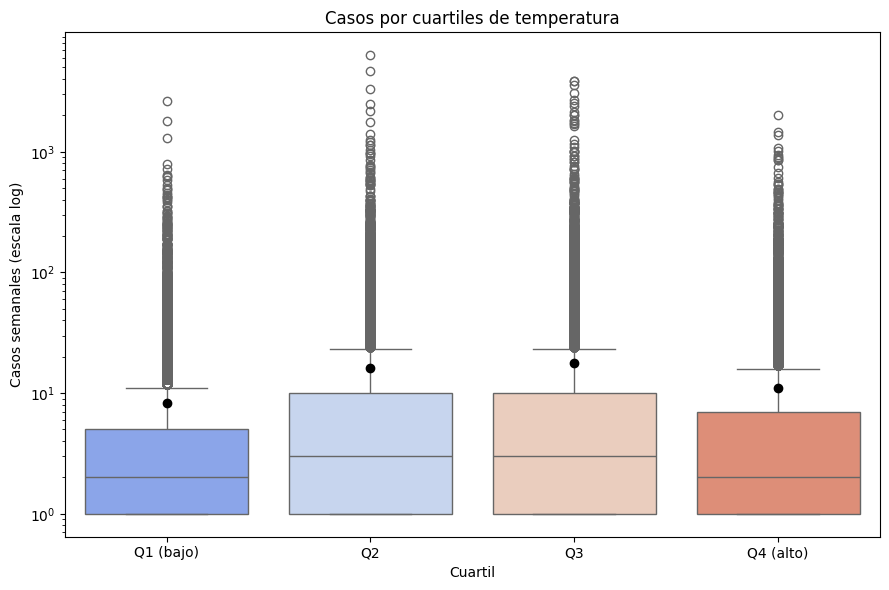


humedad — medias/medianas por cuartil


,mean,median,count
hum_sem_prom_q,,,
Q1 (bajo),8.587108,2.0,15963
Q2,12.822641,2.0,15962
Q3,13.864303,3.0,15962
Q4 (alto),17.936537,3.0,15962


/tmp/ipython-input-1610114635.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


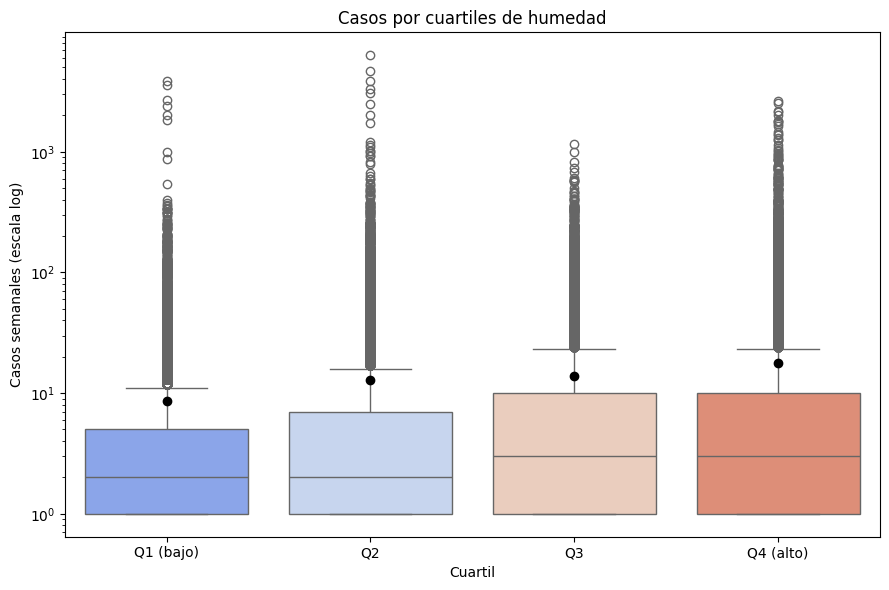

In [ ]:
# --- 1) Cuartiles y boxplots (sin stripplot) para temp y hum ---

# Orden de cuartiles usado en tablas y ejes
ORDER_Q = ["Q1 (bajo)","Q2","Q3","Q4 (alto)"]

# Etiquetas "bonitas" para títulos
CLIMA_COLS = {
    "temp_sem_prom": "temperatura",
    "hum_sem_prom":  "humedad",
}

def make_quartiles(s: pd.Series, labels=ORDER_Q):
    """
    qcut sobre rank para destrabar empates.
    Si hay pocos valores únicos y qcut no puede formar 4 bins, caemos a terciles/dos bins
    y reetiquetamos lo que haya.
    """
    r = s.rank(method="first")
    for q in (4, 3, 2):  # intentar 4 cuartiles; si no, 3; si no, 2
        try:
            bins = pd.qcut(r, q=q, labels=labels[:q], duplicates="drop")
            # si por algún motivo devuelve menos categorías, reetiquetar y salir
            if hasattr(bins, "cat"):
                bins = bins.cat.rename_categories(labels[:bins.cat.categories.size])
            return bins
        except ValueError:
            continue
    # fallback: todo a Q1 (raro, pero evita romper)
    return pd.Series(pd.Categorical(["Q1 (bajo)"] * len(s), categories=labels, ordered=True), index=s.index)

# Detectar columna de casos si no está definida
if 'case_col' not in globals() or case_col not in df_grouped.columns:
    candidate_case_cols = ["cantidad_casos","casos","n_casos","count_casos"]
    case_col = next((c for c in candidate_case_cols if c in df_grouped.columns), None)
    if case_col is None:
        raise ValueError("No encuentro columna de casos (cantidad_casos/casos/n_casos/count_casos).")

resultados = {}
for var in ["temp_sem_prom","hum_sem_prom"]:
    if var not in df_grouped.columns:
        continue

    df_grouped[f"{var}_q"] = make_quartiles(df_grouped[var])

    tabla = (df_grouped
             .groupby(f"{var}_q", observed=False)[case_col]
             .agg(mean="mean", median="median", count="count")
             .reindex(ORDER_Q))
    resultados[var] = tabla
    print(f"\n{CLIMA_COLS.get(var, var)} — medias/medianas por cuartil")
    display(tabla)

    # Boxplot en escala log (sin puntos grises)
    plt.figure(figsize=(9,6))
    sns.boxplot(
        data=df_grouped,
        x=f"{var}_q", y=case_col,
        order=ORDER_Q,
        palette="coolwarm",
        showmeans=True,
        meanprops={"marker":"o","markerfacecolor":"black","markeredgecolor":"black","markersize":"6"}
    )
    plt.yscale("log")           # quitar si preferís lineal
    plt.title(f"Casos por cuartiles de {CLIMA_COLS.get(var, var)}")
    plt.xlabel("Cuartil")
    plt.ylabel("Casos semanales (escala log)")
    plt.tight_layout()
    plt.show()


La hipotesis se confirma en cierta parte ya que en el caso de la temperatura podemos ver que tanto en niveles Medios como Medios-Altos, la cantidad de casos es bastante similar mientras que en los Altos, es menor. En cuanto a la humedad se puede ver que si se confirma ya que en los niveles Medios-Altos y Altos la cantidad de casos es mayor.

##Hipotesis 2
Planteo: Dependiendo el tipo de region, es la relacion entre temperatura/humedad y cantidad de casos.

- Comparar niveles de casos entre regiones climáticas.

- Evaluar si la temperatura semanal tiene mayor efecto sobre los casos en regiones Subtropicales que en Templado, Frio/Montaña y Arido/Semiarido.



,provincia_nombre,departamento_nombre,anio,semana_epidemiologica,fecha_semana,temp_sem_prom,hum_sem_prom,prec_sem_prom,clima_region,densidad,grupo_edad_id,grupo_edad_desc,grupo_edad_desc_std,cantidad_casos,temp_sem_prom_q,hum_sem_prom_q
0,BUENOS AIRES,25 DE MAYO,2023,13,2023-03-27,18.542857,58.714286,4.000000,TEMPLADO,7.425821,3,De 10 a 14 años,10 a 14,1,Q2,Q1 (bajo)
1,BUENOS AIRES,25 DE MAYO,2023,13,2023-03-27,18.542857,58.714286,4.000000,TEMPLADO,7.425821,9,De 45 a 65 años,65+,1,Q2,Q1 (bajo)
2,BUENOS AIRES,25 DE MAYO,2023,15,2023-04-10,16.171429,66.285714,1.142857,TEMPLADO,7.425821,5,De 20 a 24 años,20 a 24,1,Q1 (bajo),Q1 (bajo)
3,BUENOS AIRES,25 DE MAYO,2023,16,2023-04-17,14.714286,68.285714,0.428571,TEMPLADO,7.425821,6,De 25 a 34 años,25 a 34,1,Q1 (bajo),Q2
4,BUENOS AIRES,25 DE MAYO,2024,7,2024-02-12,21.085714,71.714286,1.685714,TEMPLADO,7.425821,6,De 25 a 34 años,25 a 34,1,Q2,Q2



=== Correlaciones por región (Spearman) ===


,temp_sem_prom_spearman,hum_sem_prom_spearman,prec_sem_prom_spearman
clima_region,,,
ARIDO/SEMIARIDO,0.072130,0.077608,0.035252
FRIO/MONTANA,0.153884,0.148697,0.078205
SUBTROPICAL,0.034834,0.111604,0.085122
TEMPLADO,0.094898,0.114512,0.175550



=== temp_sem_prom: medias/medianas por cuartil y región ===

[ARIDO/SEMIARIDO]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
temp_sem_prom_q,,,
Q1 (bajo),5.122970,1.0,1724
Q2,11.816599,2.0,1723
Q3,13.422519,2.0,1723
Q4 (alto),9.043529,2.0,1723



[FRIO/MONTANA]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
temp_sem_prom_q,,,
Q1 (bajo),8.586989,1.0,1983
Q2,10.556228,3.0,1983
Q3,11.586989,3.0,1983
Q4 (alto),9.110439,3.0,1983



[SUBTROPICAL]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
temp_sem_prom_q,,,
Q1 (bajo),12.838795,2.0,4913
Q2,13.818034,2.0,4913
Q3,11.788724,2.0,4913
Q4 (alto),11.580297,3.0,4913



[TEMPLADO]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
temp_sem_prom_q,,,
Q1 (bajo),7.651777,2.0,7343
Q2,17.009805,3.0,7343
Q3,22.987335,4.0,7343
Q4 (alto),14.542830,2.0,7343


/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


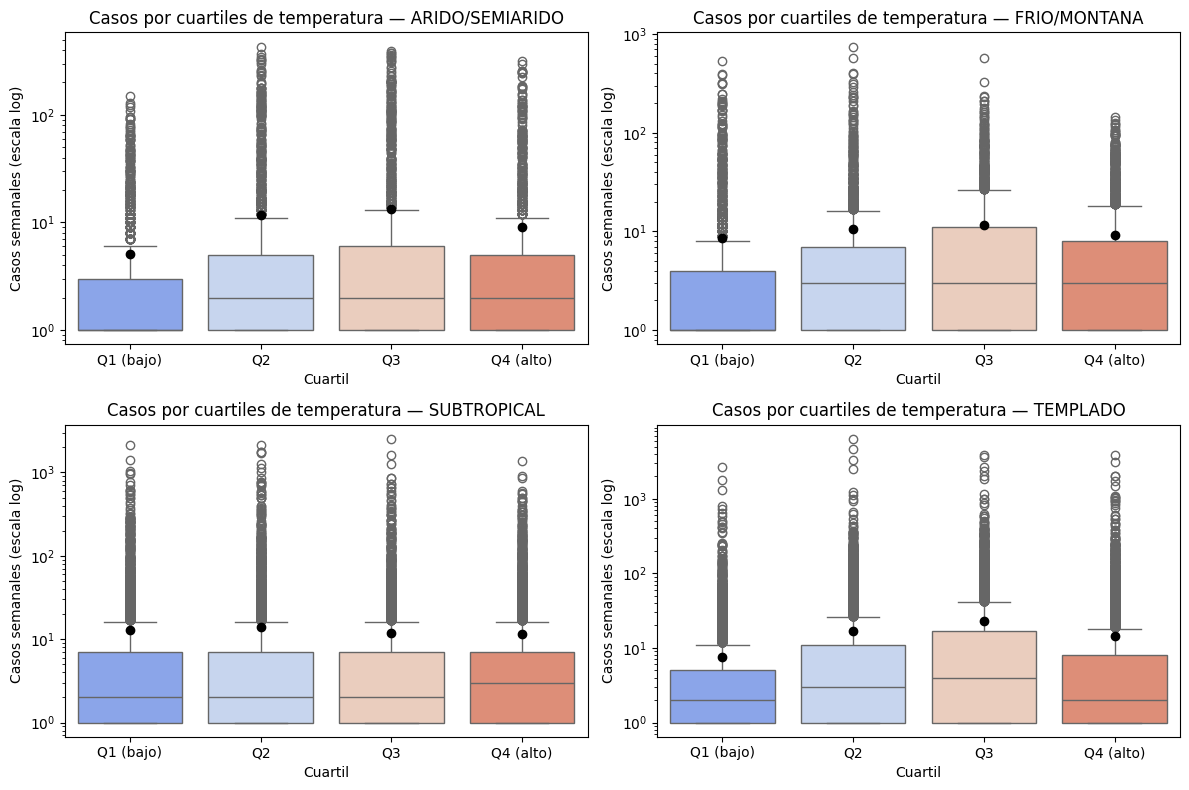


=== hum_sem_prom: medias/medianas por cuartil y región ===

[ARIDO/SEMIARIDO]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
hum_sem_prom_q,,,
Q1 (bajo),5.645592,1.0,1724
Q2,6.788160,2.0,1723
Q3,14.089379,2.0,1723
Q4 (alto),12.882182,2.0,1723



[FRIO/MONTANA]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
hum_sem_prom_q,,,
Q1 (bajo),5.507816,2.0,1983
Q2,7.326273,2.0,1983
Q3,12.097832,3.0,1983
Q4 (alto),14.908724,3.0,1983



[SUBTROPICAL]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
hum_sem_prom_q,,,
Q1 (bajo),7.667820,2.0,4913
Q2,7.682272,2.0,4913
Q3,9.985549,2.0,4913
Q4 (alto),24.690210,3.0,4913



[TEMPLADO]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
hum_sem_prom_q,,,
Q1 (bajo),11.196378,2.0,7343
Q2,17.572790,3.0,7343
Q3,16.414544,3.0,7343
Q4 (alto),17.008035,3.0,7343


/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


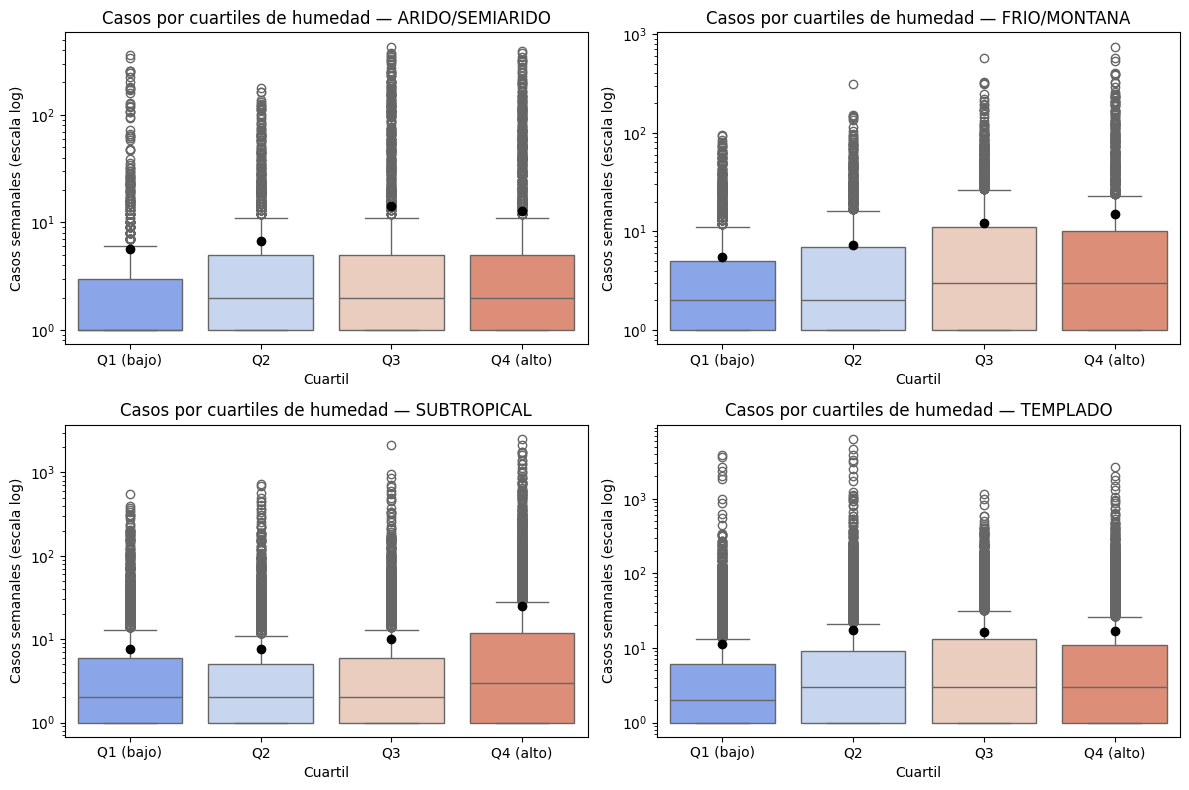


=== prec_sem_prom: medias/medianas por cuartil y región ===

[ARIDO/SEMIARIDO]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
prec_sem_prom_q,,,
Q1 (bajo),7.073666,2.0,1724
Q2,8.122461,2.0,1723
Q3,12.217644,2.0,1723
Q4 (alto),11.990714,2.0,1723



[FRIO/MONTANA]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
prec_sem_prom_q,,,
Q1 (bajo),7.027231,2.0,1983
Q2,10.554211,2.0,1983
Q3,12.595562,3.0,1983
Q4 (alto),9.663641,3.0,1983



[SUBTROPICAL]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
prec_sem_prom_q,,,
Q1 (bajo),8.151028,2.0,4913
Q2,12.192347,2.0,4913
Q3,16.375331,3.0,4913
Q4 (alto),13.307144,3.0,4913



[TEMPLADO]


/tmp/ipython-input-1846939507.py:72: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabla = (g.groupby(f"{var}_q")[case_col]


,mean,median,count
prec_sem_prom_q,,,
Q1 (bajo),11.322620,2.0,7343
Q2,11.381452,2.0,7343
Q3,20.448863,3.0,7343
Q4 (alto),19.038812,4.0,7343


/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1846939507.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


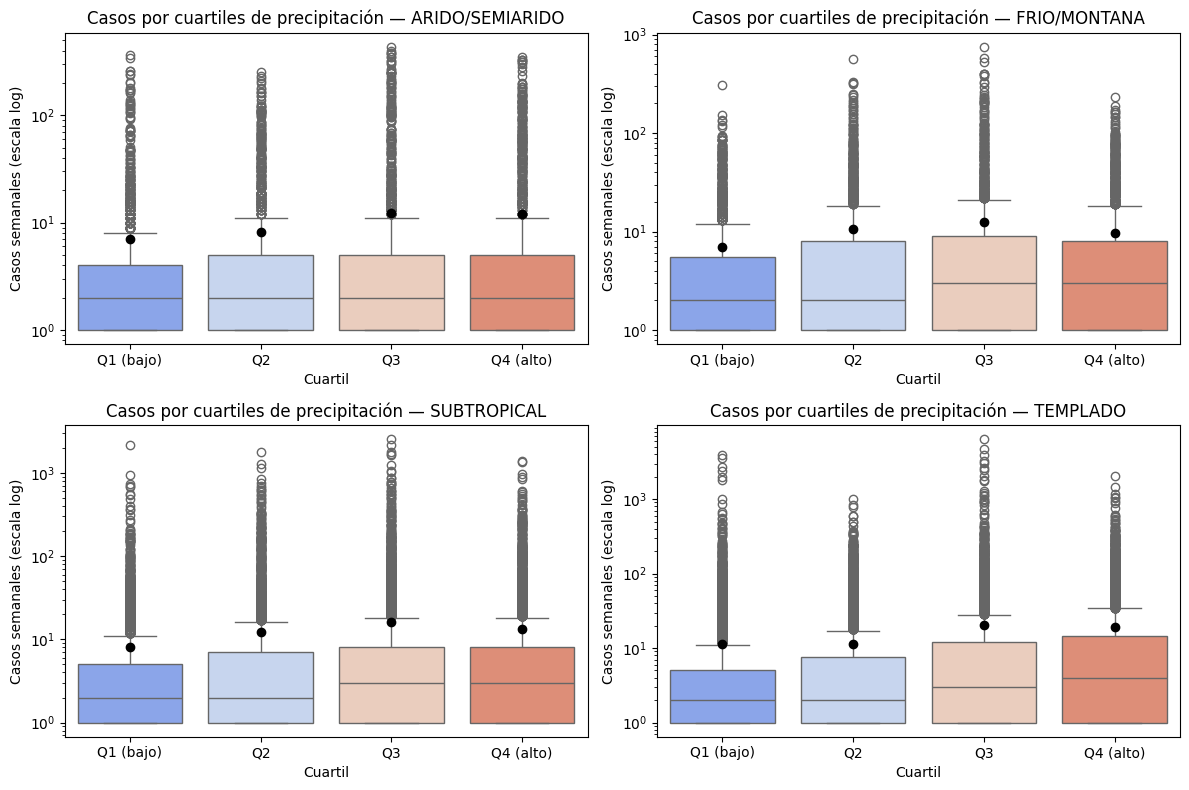

In [ ]:
# ======================================================
# HIPÓTESIS 2 por región climática: clima -> casos
# ======================================================

# -------- 0) Detectar DF base y columna de casos -------------------

df_hipo = df_grouped.copy()
display(df_hipo.head())

candidate_case_cols = ["cantidad_casos","casos","n_casos","count_casos"]
case_col = next((c for c in candidate_case_cols if c in df_hipo.columns), None)
if case_col is None:
    raise ValueError("No encuentro la columna de casos (cantidad_casos/casos/n_casos/count_casos).")

# -------- 1) Asegurar 'clima_region' ya mapeada (sin reclasificar) ----
# Si el DF base no trae 'clima_region', intentamos transferirlo desde 'df'
if "clima_region" not in df_hipo.columns:
    if 'df' in globals() and "clima_region" in df.columns and "provincia_nombre" in df_hipo.columns:
        prov2reg = (df[["provincia_nombre","clima_region"]]
                    .dropna()
                    .drop_duplicates()
                    .groupby("provincia_nombre")["clima_region"]
                    .agg(lambda s: s.value_counts().idxmax())
                    .to_dict())
        df_hipo["clima_region"] = df_hipo["provincia_nombre"].map(prov2reg)

# Si aún no hay clima_region, detenemos: el mapeo debe haberse corrido antes.
if "clima_region" not in df_hipo.columns:
    raise ValueError("Falta 'clima_region' en el DataFrame base. Corré antes el mapeo nuevo de provincias -> clima_region.")

# Eliminamos filas sin región (idealmente no debería haber, porque tu mapeo cubre 100%)
df_hipo = df_hipo.dropna(subset=["clima_region"]).copy()

# -------- 2) Variables climáticas disponibles ----------------------
vars_clima = [c for c in ["temp_sem_prom","hum_sem_prom","prec_sem_prom"]
              if c in df_hipo.columns and is_numeric_dtype(df_hipo[c])]
if not vars_clima:
    raise ValueError("No hay variables climáticas numéricas (esperaba temp_semana/hum_semana/prec_semana).")

# -------- 3) Correlaciones por región (Spearman) -------------------
print("\n=== Correlaciones por región (Spearman) ===")
corr_tab = []
for reg, g in df_hipo.groupby("clima_region"):
    row = {"clima_region": reg}
    for var in vars_clima:
        row[f"{var}_spearman"] = g[case_col].corr(g[var], method="spearman")
    corr_tab.append(row)

corr_df = pd.DataFrame(corr_tab).set_index("clima_region").sort_index()
display(corr_df)

# -------- 4) Cuartiles y boxplots por región -----------------------
def make_quartiles(s: pd.Series, labels=("Q1 (bajo)","Q2","Q3","Q4 (alto)")):
    # rank(method="first") evita empates exactos al cortar cuartiles
    return pd.qcut(s.rank(method="first"), q=4, labels=labels)

def plot_by_region(var, title_base):
    if var not in df_hipo.columns:
        print(f"⚠️ No existe {var} en el DataFrame base, se omite.")
        return

    order_q = ["Q1 (bajo)","Q2","Q3","Q4 (alto)"]
    regiones = sorted(df_hipo["clima_region"].dropna().unique())

    # crear cuartiles DENTRO de cada región (sin modificar el df original)
    tmp = df_hipo.copy()
    tmp[f"{var}_q"] = tmp.groupby("clima_region")[var].transform(make_quartiles)

    # tabla resumen Q1..Q4 por región
    print(f"\n=== {var}: medias/medianas por cuartil y región ===")
    for reg, g in tmp.groupby("clima_region"):
        tabla = (g.groupby(f"{var}_q")[case_col]
                   .agg(mean="mean", median="median", count="count")
                   .reindex(order_q))
        print(f"\n[{reg}]")
        display(tabla)

    # Facetas de boxplots: 2 columnas
    n = len(regiones)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), squeeze=False)

    for i, reg in enumerate(regiones):
        ax = axes[i // ncols, i % ncols]
        g = tmp[tmp["clima_region"] == reg]
        sns.boxplot(
            data=g, x=f"{var}_q", y=case_col,
            order=order_q, palette="coolwarm",
            showmeans=True,
            meanprops={"marker":"o","markerfacecolor":"black","markeredgecolor":"black","markersize":"6"},
            ax=ax
        )
        ax.set_yscale("log")
        ax.set_title(f"{title_base} — {reg}")
        ax.set_xlabel("Cuartil")
        ax.set_ylabel("Casos semanales (escala log)")

    # quitar ejes vacíos si los hubiera
    for j in range(i+1, nrows*ncols):
        fig.delaxes(axes[j // ncols, j % ncols])

    plt.tight_layout()
    plt.show()

# ---- ejecutar con las variables disponibles ------------------------
if "temp_sem_prom" in vars_clima:
    plot_by_region("temp_sem_prom", "Casos por cuartiles de temperatura")

if "hum_sem_prom" in vars_clima:
    plot_by_region("hum_sem_prom",  "Casos por cuartiles de humedad")

if "prec_sem_prom" in vars_clima:
    plot_by_region("prec_sem_prom", "Casos por cuartiles de precipitación")


La hipótesis de que la relación clima-dengue varía por región se confirma. Ademas a rasgos generales se puede observar que la region con menores casos sin importar la variable que se este evaluando es la de Arido/Semi-Arido.  

Observaciones Grafica de Precipitacion:
  - Cuando las precipitaciones son medias-altas y altas se pueden observar mayores cantidad de casos tanto en las zonas Templadas, Frio/Montaña y Subtropical.
  - En las zonas Subtropicales la cantidad minima de casos es mayor a las de las otras zonas cuando las precipitaciones son Bajas y Medias.
  - Las zonas Templadas tienen mayor cantidad de casos cuando las precipitaciones son Medias-Altas y Altas.

Observaciones Grafica de Humedad:
  - Las zonas Subtropicales tienen mayor cantidad de casos cuando la humedad es Alta.
  - En las zonas Frio/Montaña existe una relacion lineal o semi-lineal entre la humedad y la cantidad de casos. Se puede observar que la cantidad de casos es extramadamente menor cuando la humedad es baja, posteriormente ambas van aumentando casi del mismo modo.
  - En las zonas Templadas se puede ver un aumento de casos cuando la humedad es Media-Alta, superando asi cuando la misma es Alta.

Observaciones Grafica de Temperatura:
  - La menor cantidad de casos se encuentra en las zonas Frio/Montaña cuando la temperatura es baja.
  - En las zonas Templadas podemos ver un comportamiento similar igual que con la humedad.
  - En las zonas Subtropicales podemos ver que la cantidad de casos se mantiene uniforme independientemente de la temperatura.

###Pruebas con otras graficas (Hipotesis 2)


=== Visualizaciones para la Región SUBTROPICAL ===


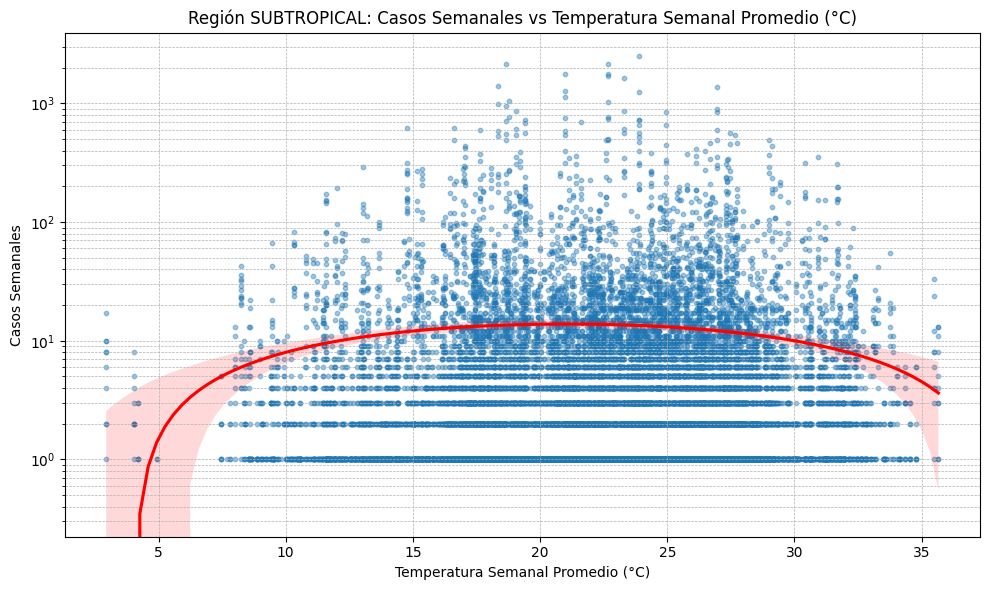

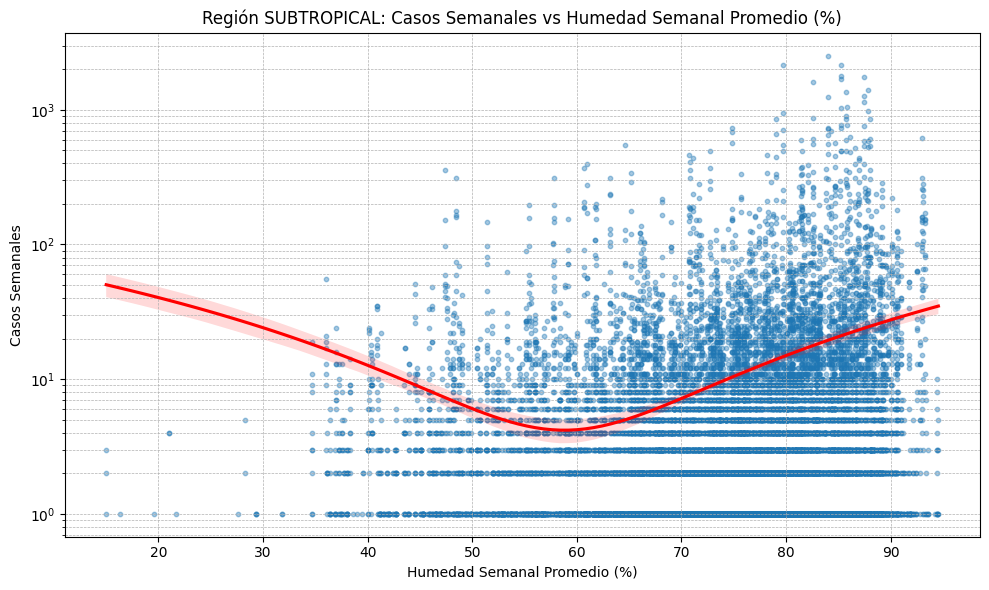

In [ ]:
# ======================================================
# Visualizaciones para la Región SUBTROPICAL (Hipótesis 2)
# ======================================================

df_hipo = df_grouped.copy()


candidate_case_cols = ["cantidad_casos","casos","n_casos","count_casos"]
case_col = next((c for c in candidate_case_cols if c in df_hipo.columns), None)
if case_col is None:
    raise ValueError("No encuentro la columna de casos (cantidad_casos/casos/n_casos/count_casos).")

if "clima_region" not in df_hipo.columns:
     raise ValueError("Falta 'clima_region' en el DataFrame base. Corré antes el mapeo nuevo de provincias -> clima_region.")

# Filtrar solo la región SUBTROPICAL
df_subtropical = df_hipo[df_hipo["clima_region"] == "SUBTROPICAL"].copy()

if df_subtropical.empty:
    print("⚠️ No hay datos para la región SUBTROPICAL.")
else:
    print("\n=== Visualizaciones para la Región SUBTROPICAL ===")

    # -------- Scatter plots con línea de tendencia (SUBTROPICAL) -------------------

    vars_to_plot = {
        "temp_sem_prom": "Temperatura Semanal Promedio (°C)",
        "hum_sem_prom":  "Humedad Semanal Promedio (%)",
        # "prec_sem_prom": "Precipitación Semanal Promedio (mm)" # Opcional: descomentar si también quieres precipitación
    }

    for var, title_label in vars_to_plot.items():
        if var not in df_subtropical.columns or not is_numeric_dtype(df_subtropical[var]):
            print(f"⚠️ Variable {var} no disponible o no numérica en la región SUBTROPICAL. Se omite.")
            continue

        plt.figure(figsize=(10, 6))
        sns.regplot(
            data=df_subtropical,
            x=var,
            y=case_col,
            scatter_kws={'alpha':0.4, 's':10},
            line_kws={'color':'red'},
            order=2 # Considerar relación no lineal (cuadrática)
        )
        plt.title(f"Región SUBTROPICAL: Casos Semanales vs {title_label}")
        plt.xlabel(title_label)
        plt.ylabel("Casos Semanales")
        plt.yscale("log") # Escala logarítmica en Y para manejar la dispersión
        plt.grid(True, which="both", linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()


## Hipotesis 3
Planteo: La provincia con mas casos pertenece a zonas Subtropicales.

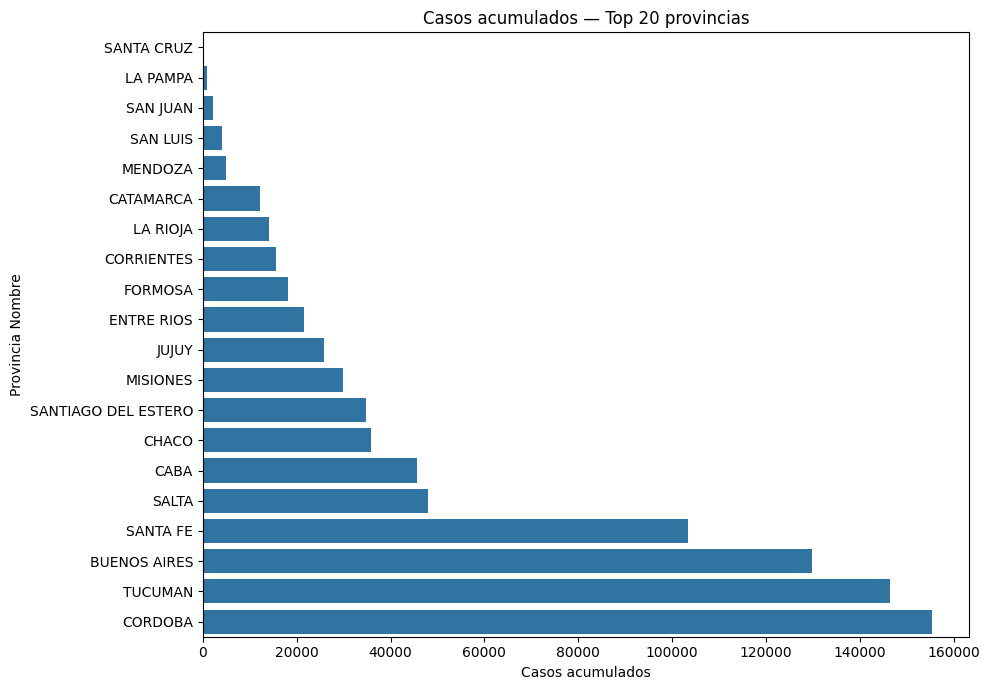

In [ ]:
# ================================================================
# HIPÓTESIS 3: Provincia -> Casos en provincia de zona Subtropical
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype

# ---------- Configuración ----------
DF_BASE = df_grouped.copy()     # <-- tu DF
GEO_LEVEL = "provincia"         # "provincia" o "departamento"
TOP_N = 20                      # top N geos por casos para barras/small multiples
CASE_CANDIDATES = ["cantidad_casos","casos","n_casos","count_casos"]
DATE_COL_CAND = ["fecha_semana","fecha","semana"]

# ---------- Detectar columnas ----------
case_col = next((c for c in CASE_CANDIDATES if c in DF_BASE.columns and is_numeric_dtype(DF_BASE[c])), None)
if case_col is None:
    raise ValueError("No encuentro columna de casos (cantidad_casos/casos/n_casos/count_casos).")

date_col = next((c for c in DATE_COL_CAND if c in DF_BASE.columns), None)
if date_col is None:
    raise ValueError("No encuentro columna de fecha (por ej. 'fecha_semana').")

if GEO_LEVEL.lower().startswith("prov"):
    geo_col = "provincia_nombre"
elif GEO_LEVEL.lower().startswith("depa"):
    geo_col = "departamento_nombre"
else:
    raise ValueError("GEO_LEVEL debe ser 'provincia' o 'departamento'.")

if geo_col not in DF_BASE.columns:
    raise ValueError(f"No encuentro la columna geográfica esperada: {geo_col}")

# Asegurar tipos
DF_BASE = DF_BASE.dropna(subset=[geo_col, case_col]).copy()
# Si la fecha es string, intentar parsear
if not np.issubdtype(DF_BASE[date_col].dtype, np.datetime64):
    with pd.option_context("mode.chained_assignment", None):
        DF_BASE[date_col] = pd.to_datetime(DF_BASE[date_col], errors="coerce")
DF_BASE = DF_BASE.dropna(subset=[date_col]).copy()

# ---------- 1) Barras: Top N geos por casos acumulados ----------
def plot_top_bars(df=DF_BASE, geo=geo_col, ycol=case_col, topn=TOP_N, titulo_prefix="Casos acumulados"):
    agg = (df.groupby(geo, observed=False)[ycol]
             .sum()
             .sort_values(ascending=False)
             .head(topn)
             .iloc[::-1])  # invertimos para que el mayor quede arriba en la barra horizontal
    plt.figure(figsize=(10, max(5, topn * 0.35)))
    sns.barplot(x=agg.values, y=agg.index)
    plt.xlabel("Casos acumulados")
    plt.ylabel(geo.replace("_", " ").title())
    plt.title(f"{titulo_prefix} — Top {len(agg)} {GEO_LEVEL}s")
    plt.tight_layout()
    plt.show()

# ================== EJEMPLOS DE USO ==================
# 1) Barras Top N (por provincia o departamento según GEO_LEVEL):
plot_top_bars()

La hipotesis no se confirma debido a que la Top 1 es Cordoba, la cual pertenece a zonas Templadas. Si se puede observar que Tucuman, una de las provincias de las zonas Subtropicales, es Top 2.

## Hipotesis 4
Planteo: De las regiones Templadas/Subtropicales, los departamentos con mayor densidad tienen mayor cantidad de casos.

- Filtrar por las regiones templadas/subtropical.
- Comparar con Spearman y Pearson.
- Grafico Scatter comparando los datos de la densidad, departamento y casos.


=== Correlaciones POR DEPARTAMENTO (casos totales ~ densidad) ===


,Spearman,Pearson,n_deptos
clima_region,,,
ARIDO/SEMIARIDO,0.560507,0.032146,94
FRIO/MONTANA,0.668607,0.090536,84
SUBTROPICAL,0.584742,0.874134,94
TEMPLADO,0.688468,0.096054,226


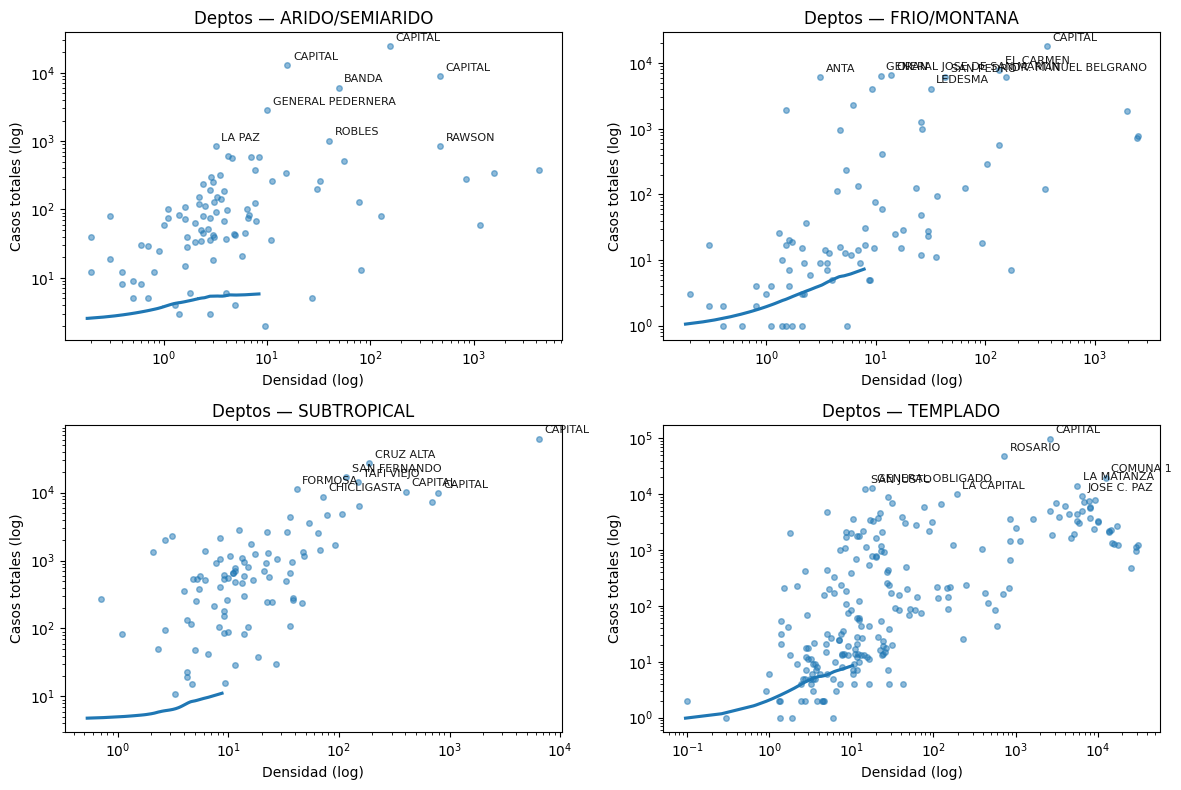

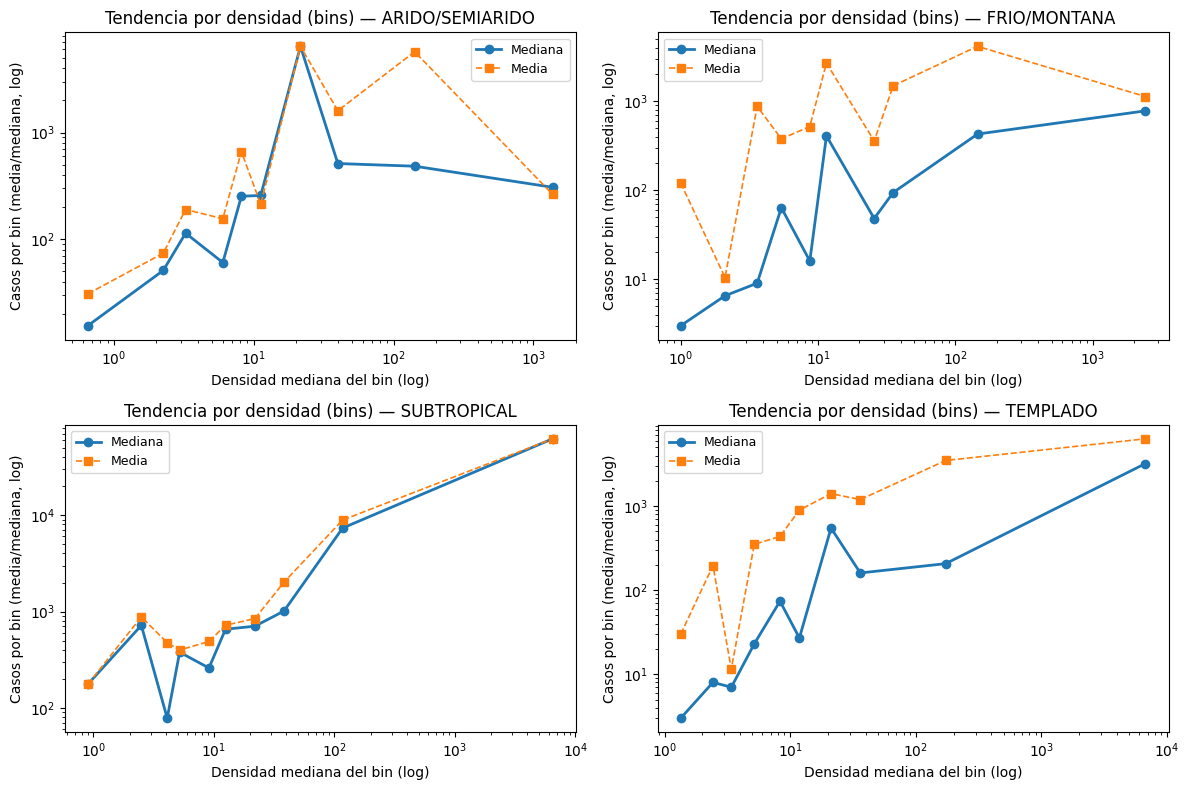

In [ ]:

# ======================================================
# HIPÓTESIS 4 : densidad -> casos (TEMPLADO/SUBTROPICAL)
# ======================================================


# ---------- 0) DF base ----------
df_h3 = df_grouped.copy()

# ---------- 1) Validaciones ----------
need_cols = {
    "provincia_nombre","departamento_nombre","fecha_semana","clima_region",
    "densidad","cantidad_casos"
}
miss = [c for c in need_cols if c not in df_h3.columns]
if miss:
    raise ValueError(f"Faltan columnas requeridas: {miss}")

if not np.issubdtype(df_h3["fecha_semana"].dtype, np.datetime64):
    df_h3["fecha_semana"] = pd.to_datetime(df_h3["fecha_semana"], errors="coerce")

# ---------- 2) Filtro de regiones ----------
reg_keep = {"TEMPLADO","SUBTROPICAL","ARIDO/SEMIARIDO","FRIO/MONTANA"}
df_h3 = df_h3[df_h3["clima_region"].isin(reg_keep)].dropna(subset=["densidad","cantidad_casos"]).copy()
if df_h3.empty:
    raise ValueError("No hay datos en TEMPLADO/SUBTROPICAL tras el filtro.")

y = "cantidad_casos"
x = "densidad"

# ---------- 3) Funciones auxiliares ----------
def spearman(a,b):
    if len(a) < 3: return np.nan
    return pd.Series(a).corr(pd.Series(b), method="spearman")
def pearson(a,b):
    if len(a) < 3: return np.nan
    return pd.Series(a).corr(pd.Series(b), method="pearson")

def quantile_bins(x, q=10):
    r = pd.Series(x).rank(method="first")
    return pd.qcut(r, q=q, labels=[f"B{i}" for i in range(1,q+1)])

def summarize_by_bins(df, x="densidad", y="cantidad_casos", q=10):
    tmp = df.copy()
    tmp["_bin"] = quantile_bins(tmp[x], q=q)
    g = (tmp.groupby(["clima_region","_bin"], observed=False)
           .agg(dens_med=(x,"median"),
                y_mean=(y,"mean"),
                y_med=(y,"median"),
                n=(y,"count"))
           .reset_index())
    g = g.sort_values(["clima_region","dens_med"]).reset_index(drop=True)
    return g


# =====================================
# A) ANÁLISIS AGREGADO POR DEPARTAMENTO
# =====================================

agg = (df_h3.groupby(["clima_region","provincia_nombre","departamento_nombre"], observed=False)
         .agg(casos_totales=(y,"sum"), densidad=(x,"mean"))
         .reset_index())

print("\n=== Correlaciones POR DEPARTAMENTO (casos totales ~ densidad) ===")
rows = []
for reg, g in agg.groupby("clima_region", observed=False):
    rows.append({
        "clima_region": reg,
        "Spearman": spearman(g["densidad"], g["casos_totales"]),
        "Pearson":  pearson(g["densidad"], g["casos_totales"]),
        "n_deptos": len(g)
    })
corr_dep = pd.DataFrame(rows).set_index("clima_region").sort_index()
display(corr_dep)


# Scatter agregado por departamento (log-log) + LOWESS
regs = sorted(df_h3["clima_region"].dropna().unique())

n = len(regs)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), squeeze=False)
for i, reg in enumerate(regs):
    ax = axes[i//ncols, i%ncols]
    g = agg[agg["clima_region"]==reg]
    ax.scatter(g["densidad"], g["casos_totales"], s=16, alpha=0.5)
    ax.set_xscale("log"); ax.set_yscale("log")
    try:
        sns.regplot(x=np.log1p(g["densidad"]), y=np.log1p(g["casos_totales"]),
                    lowess=True, scatter=False, ax=ax)
    except Exception:
        pass
    # Etiquetar 8 outliers por casos
    for _, r in g.nlargest(8, "casos_totales").iterrows():
        ax.annotate(r["departamento_nombre"], (r["densidad"], r["casos_totales"]),
                    textcoords="offset points", xytext=(4,4), fontsize=8, alpha=0.9)
    ax.set_title(f"Deptos — {reg}")
    ax.set_xlabel("Densidad (log)"); ax.set_ylabel("Casos totales (log)")
for j in range(i+1, nrows*ncols): fig.delaxes(axes[j//ncols, j%ncols])
plt.tight_layout(); plt.show()

# Tendencia por bins (igual N por bin) en agregado
bins_dep = summarize_by_bins(agg.rename(columns={"casos_totales": "Y"}), x="densidad", y="Y", q=10)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), squeeze=False)
for i, reg in enumerate(regs):
    ax = axes[i//ncols, i%ncols]
    g = bins_dep[bins_dep["clima_region"]==reg]
    ax.plot(g["dens_med"], g["y_med"], marker="o", linewidth=2, label="Mediana")
    ax.plot(g["dens_med"], g["y_mean"], marker="s", linestyle="--", linewidth=1.2, label="Media")
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(f"Tendencia por densidad (bins) — {reg}")
    ax.set_xlabel("Densidad mediana del bin (log)")
    ax.set_ylabel("Casos por bin (media/mediana, log)")
    ax.legend(fontsize=9)
for j in range(i+1, nrows*ncols): fig.delaxes(axes[j//ncols, j%ncols])
plt.tight_layout(); plt.show()

La Hipotesis se confirma parcialmente, podemos observar en el grafico Binscatter se muestra un compartamiento lineal en la region Subtropical demostrando que hay una relacion casi 1 a 1 entre la densidad y los casos confirmados de dengue.

En cambio en la region Templada podemos observar que aunque la relacion es proporcional llega una instancia en que la cantidad de casos se mantiene a pesar de que aumenta la densidad del lugar.

ORGANIZAR POR FECHA

In [ ]:
# ============================================
# Picos de casos confirmados por clima_region
# ============================================

df_peaks = df.copy()

# --- 0) Normalización mínima de columnas (opcional) ---
# Si tu df ya trae "fecha_semana" como datetime, no hace falta tocar esto.
# Si NO existe "fecha_semana" pero sí (anio, semana_epidemiologica), la construimos.
if "fecha_semana" not in df_peaks.columns:
    if {"anio", "semana_epidemiologica"}.issubset(df_peaks.columns):
        # Construye la fecha (lunes de cada semana)
        df_peaks["fecha_semana"] = pd.to_datetime(df_peaks["anio"].astype(str) + "-W" + df_peaks["semana_epidemiologica"].astype(str) + "-1", errors="coerce", format="%G-W%V-%u")
    else:
        raise ValueError("No existe 'fecha_semana' ni (anio, semana_epidemiologica). Necesito una de esas opciones para fechar.")

# Asegurar tipo datetime
if not np.issubdtype(df_peaks["fecha_semana"].dtype, np.datetime64):
    df_peaks["fecha_semana"] = pd.to_datetime(df_peaks["fecha_semana"], errors="coerce")

# --- 1) Filtro de dengue confirmado ---
# Tu dataset a veces ya viene agregado y/o solo con dengue.
# Si tenés columna de clasificación/estado, usá el filtro de 'CONFIRM' (ajustá nombres si hace falta).
mask = pd.Series(True, index=df_peaks.index)

# (opcional) Si existe una columna de evento, filtrar por "DENGUE".
for col_ev in ["evento_nombre", "evento", "enfermedad", "evento_desc"]:
    if col_ev in df_peaks.columns:
        mask &= df_peaks[col_ev].astype(str).str.upper().str.contains("DENGUE", na=False)
        break

# (opcional) Si existe una columna de clasificación, filtrar "confirmado".
for col_cl in ["clasificacion", "condicion", "estado_caso", "tipo_caso", "clasificacion_final"]:
    if col_cl in df_peaks.columns:
        mask &= df_peaks[col_cl].astype(str).str.upper().str.contains("CONFIRM", na=False)
        break

df_peaks = df_peaks[mask].copy()

# --- 2) Columnas necesarias ---
# 'cantidad_casos' es la métrica principal en tu colab.
if "cantidad_casos" not in df_peaks.columns:
    # Fallback: si no está, intentar 'casos' o 'n_casos'
    for alt in ["casos", "n_casos", "cantidad", "count"]:
        if alt in df_peaks.columns:
            df_peaks["cantidad_casos"] = df_peaks[alt]
            break
    if "cantidad_casos" not in df_peaks.columns:
        raise ValueError("No encuentro la columna de conteo de casos ('cantidad_casos'). Ajustá el nombre en esta celda.")

# Chequeo de la columna de región
if "clima_region" not in df_peaks.columns:
    raise ValueError("Falta 'clima_region'. Ejecutá antes la celda de mapeo de provincias a clima_region.")

# --- 3) Agregación semanal por región ---
ts_region = (
    df_peaks
      .groupby(["clima_region", "fecha_semana"], as_index=False)["cantidad_casos"]
      .sum()
      .sort_values(["clima_region", "fecha_semana"])
)

# --- 4) Top N picos por región ---
TOP_N = 5  # <- podés cambiar cuántos picos querés listar
peaks_por_region = (
    ts_region
      .sort_values(["clima_region", "cantidad_casos"], ascending=[True, False])
      .groupby("clima_region")
      .head(TOP_N)
      .sort_values(["clima_region", "cantidad_casos"], ascending=[True, False])
      .reset_index(drop=True)
)

display(ts_region.head())
display(peaks_por_region)

print("✔️ Agregado listo: 'ts_region' (serie temporal por región) y 'peaks_por_region' (top picos por región).")


,clima_region,fecha_semana,cantidad_casos
0,ARIDO/SEMIARIDO,2018-01-29,3
1,ARIDO/SEMIARIDO,2018-04-02,1
2,ARIDO/SEMIARIDO,2018-04-09,7
3,ARIDO/SEMIARIDO,2018-04-16,35
4,ARIDO/SEMIARIDO,2018-04-23,36


,clima_region,fecha_semana,cantidad_casos
0,ARIDO/SEMIARIDO,2024-04-01,6709
1,ARIDO/SEMIARIDO,2024-04-08,6156
2,ARIDO/SEMIARIDO,2024-03-25,5604
3,ARIDO/SEMIARIDO,2024-03-18,5317
4,ARIDO/SEMIARIDO,2024-04-15,4171
5,FRIO/MONTANA,2024-04-08,7306
6,FRIO/MONTANA,2024-04-01,7187
7,FRIO/MONTANA,2024-03-18,5642
8,FRIO/MONTANA,2024-03-25,5427
9,FRIO/MONTANA,2024-04-15,4827


✔️ Agregado listo: 'ts_region' (serie temporal por región) y 'peaks_por_region' (top picos por región).


# Detección de picos por región y año (>=2023)
 - Encuentra ventanas de "pico" (inicio/fin)
  - Calcula semana pico, duración y acumulado
  - Marca semanas con incremento

In [ ]:
# ============================================
# Detección de picos por región y año (>=2023)
# - Encuentra ventanas de "pico" (inicio/fin)
# - Calcula semana pico, duración y acumulado
# - Marca semanas con incremento
# ============================================

import pandas as pd
import numpy as np

# ---------- Parámetros ajustables ----------
# Umbral base por región-año = max(P75, MIN_FLOOR)
MIN_FLOOR = 50            # piso mínimo del umbral
END_COOLDOWN = 2          # semanas por debajo del umbral para cerrar el pico
MERGE_GAP = 1             # si hay ≤ MERGE_GAP semanas entre picos, se fusionan
MIN_WINDOW_WEEKS = 2      # descarta ventanas muy cortas
# (Opcional) exigir crecimiento en el arranque del pico
REQUIRE_UPWARD_ON_START = True

# ---------- Datos de entrada ----------
assert "ts_region" in globals(), "Ejecutá antes la celda que construye ts_region."
df_ts = ts_region.copy()
df_ts = df_ts[df_ts["fecha_semana"] >= "2023-01-01"].copy()
df_ts["anio_cal"] = df_ts["fecha_semana"].dt.year

def compute_threshold(x: pd.Series) -> float:
    """Umbral dinámico simple por región-año: max(P75, MIN_FLOOR)."""
    if x.empty:
        return MIN_FLOOR
    p75 = np.nanpercentile(x, 50)
    return max(float(p75), MIN_FLOOR)

def detect_windows(df_group: pd.DataFrame, th: float) -> list:
    """
    Detecta ventanas de pico:
    - Start cuando cruza umbral (y opcionalmente con Δ>0)
    - End cuando acumula END_COOLDOWN semanas por debajo del umbral
    Fusiona ventanas separadas por ≤ MERGE_GAP semanas.
    Retorna lista de dicts con inicio/fin/peak/duración/suma.
    """
    df_group = df_group.sort_values("fecha_semana").reset_index(drop=True)
    cases = df_group["cantidad_casos"].to_numpy()
    dates = df_group["fecha_semana"].to_list()

    # Semanas con incremento (diff positiva)
    diff = np.diff(cases, prepend=np.nan)
    df_group["incremento"] = diff > 0

    in_peak = False
    cooldown = 0
    windows = []
    start_idx = None

    for i in range(len(df_group)):
        above = cases[i] >= th
        up_ok = True
        if REQUIRE_UPWARD_ON_START and i > 0:
            up_ok = (cases[i] - cases[i-1]) > 0

        if not in_peak:
            if above and (i == 0 or up_ok):
                # abre ventana
                in_peak = True
                start_idx = i
                cooldown = 0
        else:
            if above:
                cooldown = 0  # seguimos dentro del pico
            else:
                cooldown += 1
                if cooldown >= END_COOLDOWN:
                    # cerramos ventana en la semana anterior al fin del cooldown
                    end_idx = i - cooldown
                    if end_idx < start_idx:
                        end_idx = i-1
                    if end_idx >= start_idx:
                        windows.append((start_idx, end_idx))
                    in_peak = False
                    cooldown = 0
                    start_idx = None

    # Si quedó abierto al final
    if in_peak and start_idx is not None:
        windows.append((start_idx, len(df_group)-1))

    # Fusionar ventanas cercanas
    merged = []
    for w in windows:
        if not merged:
            merged.append(list(w))
        else:
            prev = merged[-1]
            gap = w[0] - prev[1] - 1
            if gap <= MERGE_GAP:
                prev[1] = w[1]  # fusiona
            else:
                merged.append(list(w))

    # Construir salida enriquecida y filtrar por duración mínima
    out = []
    for s, e in merged:
        if (e - s + 1) < MIN_WINDOW_WEEKS:
            continue
        seg = df_group.iloc[s:e+1]
        idx_peak = seg["cantidad_casos"].idxmax()
        peak_row = df_group.loc[idx_peak]
        out.append({
            "inicio_semana": dates[s],
            "fin_semana": dates[e],
            "semanas": int(e - s + 1),
            "peak_semana": peak_row["fecha_semana"],
            "peak_casos": int(peak_row["cantidad_casos"]),
            "casos_acum": int(seg["cantidad_casos"].sum())
        })
    return out, df_group[["fecha_semana","incremento"]].copy()

# ---------- Loop por región y año ----------
ventanas_rows = []
increments_rows = []

for (reg, anio), df_ra in df_ts.groupby(["clima_region", "anio_cal"]):
    th = compute_threshold(df_ra["cantidad_casos"])
    winlist, inc = detect_windows(df_ra, th)

    # guardar incrementos
    inc = inc.assign(clima_region=reg, anio_cal=anio)
    increments_rows.append(inc)

    # guardar ventanas
    for w in winlist:
        w.update({"clima_region": reg, "anio_cal": int(anio), "umbral": int(th)})
        ventanas_rows.append(w)

# ---------- Resultados principales ----------
ventanas_picos = pd.DataFrame(ventanas_rows).sort_values(
    ["clima_region", "anio_cal", "inicio_semana"]
).reset_index(drop=True)

semanas_incremento = pd.concat(increments_rows, ignore_index=True).sort_values(
    ["clima_region", "anio_cal", "fecha_semana"]
).reset_index(drop=True)

display(ventanas_picos)
display(semanas_incremento.head())

print("✔️ Listo: 'ventanas_picos' (intervalos pico por región-año) y 'semanas_incremento' (flag de incremento por semana).")
print(f"Parámetros: MIN_FLOOR={MIN_FLOOR}, END_COOLDOWN={END_COOLDOWN}, MERGE_GAP={MERGE_GAP}, MIN_WINDOW_WEEKS={MIN_WINDOW_WEEKS}, REQUIRE_UPWARD_ON_START={REQUIRE_UPWARD_ON_START}")


,inicio_semana,fin_semana,semanas,peak_semana,peak_casos,casos_acum,clima_region,anio_cal,umbral
0,2023-03-13,2023-05-29,12,2023-03-27,2449,15482,ARIDO/SEMIARIDO,2023,482
1,2024-02-12,2024-05-06,13,2024-04-01,6709,45170,ARIDO/SEMIARIDO,2024,994
2,2023-02-27,2023-05-29,14,2023-03-27,3168,19429,FRIO/MONTANA,2023,392
3,2024-02-12,2024-05-06,13,2024-04-08,7306,44129,FRIO/MONTANA,2024,530
4,2023-03-13,2023-06-05,13,2023-04-10,4377,32249,SUBTROPICAL,2023,1215
5,2024-01-08,2024-01-22,3,2024-01-08,6274,18250,SUBTROPICAL,2024,5988
6,2024-02-19,2024-04-29,11,2024-03-18,22911,143728,SUBTROPICAL,2024,5988
7,2025-02-17,2025-05-19,14,2025-03-10,322,1751,SUBTROPICAL,2025,71
8,2023-02-27,2023-05-22,13,2023-04-10,8709,50813,TEMPLADO,2023,520
9,2024-02-05,2024-04-29,13,2024-03-18,57712,350049,TEMPLADO,2024,4228


,fecha_semana,incremento,clima_region,anio_cal
0,2023-01-02,False,ARIDO/SEMIARIDO,2023
1,2023-01-16,True,ARIDO/SEMIARIDO,2023
2,2023-01-30,False,ARIDO/SEMIARIDO,2023
3,2023-02-06,True,ARIDO/SEMIARIDO,2023
4,2023-02-13,True,ARIDO/SEMIARIDO,2023


✔️ Listo: 'ventanas_picos' (intervalos pico por región-año) y 'semanas_incremento' (flag de incremento por semana).
Parámetros: MIN_FLOOR=50, END_COOLDOWN=2, MERGE_GAP=1, MIN_WINDOW_WEEKS=2, REQUIRE_UPWARD_ON_START=True


#Hipotesis 5

Planteo: Tomando en cuenta los datos del año 2023 en adelante, en las semanas que caen en verano, representan los meses con mas cantida de casos.

Se agrupan las semanas del año por meses. y Se compara con las distintas regiones y meses.

,clima_region,anio,mes,cantidad_casos,mes_nombre
0,ARIDO/SEMIARIDO,2023,1,4,Jan
18,FRIO/MONTANA,2023,1,37,Jan
35,SUBTROPICAL,2023,1,84,Jan
53,TEMPLADO,2023,1,138,Jan
1,ARIDO/SEMIARIDO,2023,2,184,Feb


✔️ Resultado: 'mensual_region' con acumulado de casos por región, año y mes.


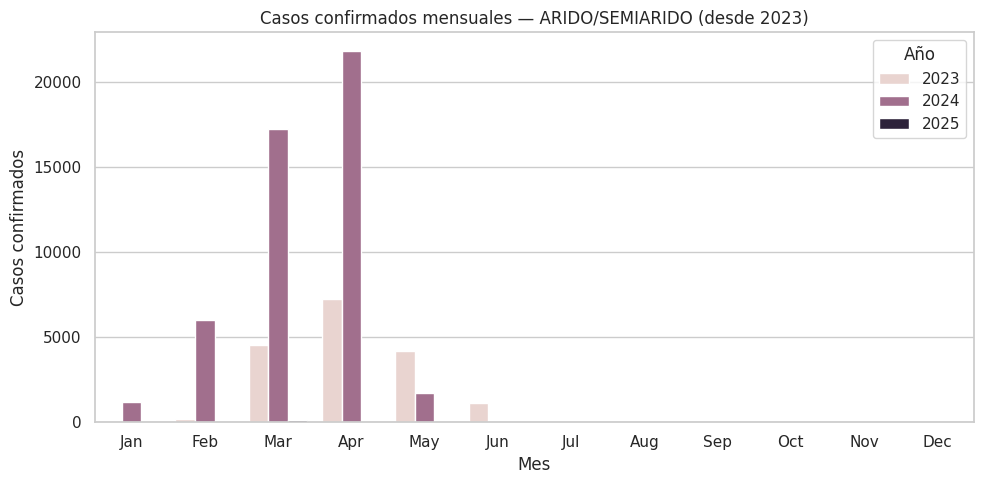

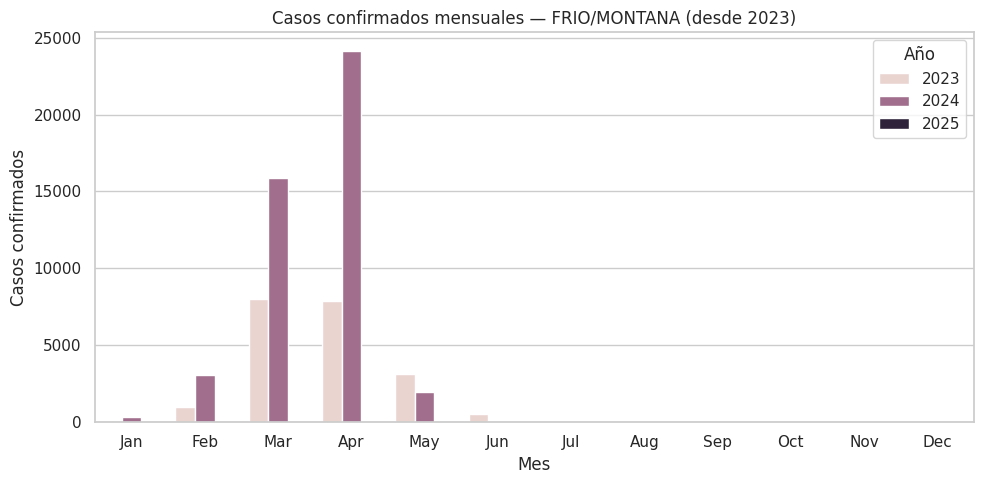

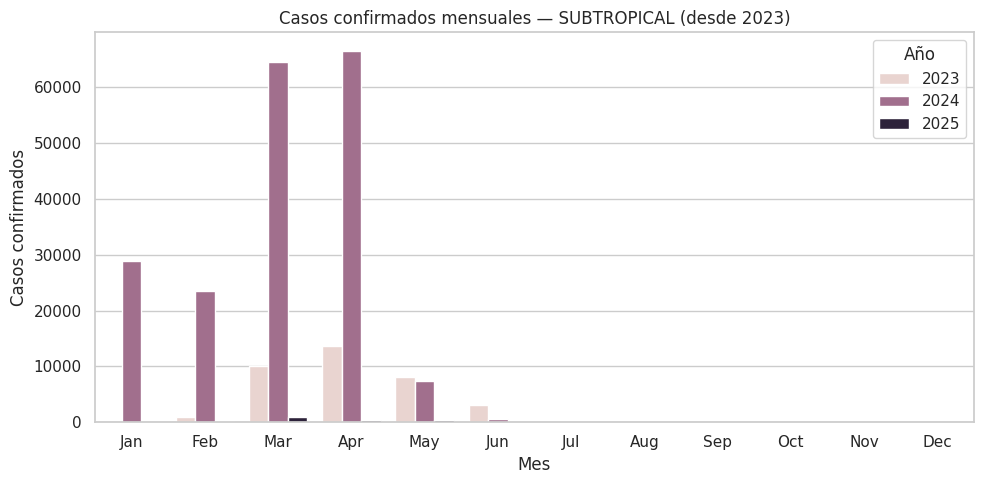

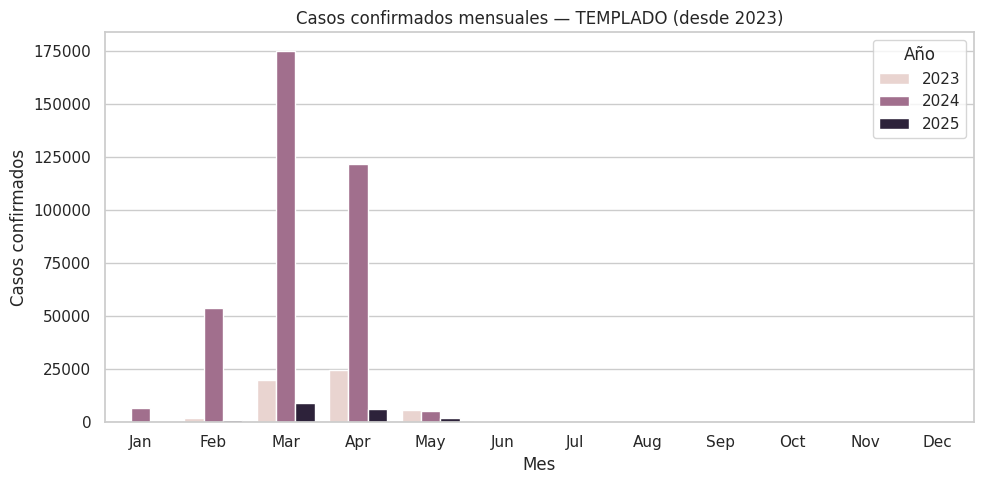

In [ ]:
# ===========================================================
# Casos acumulados por mes y región (desde 2023)
# ===========================================================

import pandas as pd
import matplotlib.pyplot as plt

# Copiar y preparar
df_monthly = ts_region.copy()
df_monthly["anio"] = df_monthly["fecha_semana"].dt.year
df_monthly["mes"] = df_monthly["fecha_semana"].dt.month

# Filtrar desde 2023
df_monthly = df_monthly[df_monthly["anio"] >= 2023].copy()

# Agregar por región, año y mes
mensual_region = (
    df_monthly
    .groupby(["clima_region", "anio", "mes"], as_index=False)["cantidad_casos"]
    .sum()
    .sort_values([ "anio", "mes","clima_region",])
)

# Crear etiqueta de mes (para el eje x)
mensual_region["mes_nombre"] = pd.to_datetime(mensual_region["mes"], format="%m").dt.strftime("%b")

display(mensual_region.head())

print("✔️ Resultado: 'mensual_region' con acumulado de casos por región, año y mes.")

# ===========================================================
# Gráfico de barras: casos mensuales por región (ordenado)
# ===========================================================

import seaborn as sns
import matplotlib.pyplot as plt
import calendar

# Configuración estética
sns.set(style="whitegrid")

# Orden cronológico de meses (en abreviatura inglesa)
meses_orden = list(calendar.month_abbr[1:])  # ['Jan', 'Feb', ..., 'Dec']

# Asegurar que todos los meses existan (aunque sin datos)
# Esto rellena meses faltantes con 0 casos
full_index = (
    pd.MultiIndex.from_product(
        [mensual_region["clima_region"].unique(),
         mensual_region["anio"].unique(),
         range(1, 13)],
        names=["clima_region", "anio", "mes"]
    )
)
mensual_completo = (
    mensual_region
    .set_index(["clima_region", "anio", "mes"])
    .reindex(full_index, fill_value=0)
    .reset_index()
)
mensual_completo["mes_nombre"] = pd.to_datetime(
    mensual_completo["mes"], format="%m"
).dt.strftime("%b")

# --- Gráfico ---
for region in mensual_completo["clima_region"].unique():
    df_r = mensual_completo[mensual_completo["clima_region"] == region]

    plt.figure(figsize=(10,5))
    sns.barplot(
        data=df_r,
        x="mes_nombre",
        y="cantidad_casos",
        hue="anio",
        order=meses_orden
    )

    plt.title(f"Casos confirmados mensuales — {region} (desde 2023)")
    plt.xlabel("Mes")
    plt.ylabel("Casos confirmados")
    plt.legend(title="Año")
    plt.tight_layout()
    plt.show()




In [ ]:
# ===========================================================
# Filtro temporal base: meses enero a junio (desde 2023)
# ===========================================================
df_periodo = df.copy()

# Crear columnas de fecha si no existen
if "fecha_semana" not in df_periodo.columns and {"anio","semana_epidemiologica"}.issubset(df_periodo.columns):
    df_periodo["fecha_semana"] = pd.to_datetime(
        df_periodo["anio"].astype(str) + "-W" + df_periodo["semana_epidemiologica"].astype(str) + "-1",
        format="%G-W%V-%u",
        errors="coerce"
    )

df_periodo["anio"] = df_periodo["fecha_semana"].dt.year
df_periodo["mes"] = df_periodo["fecha_semana"].dt.month

# Filtrar meses 1–6 y años >= 2023
df_periodo_Anual = df_periodo.copy()
#df_periodo = df_periodo.query("anio >= 2023 and 1 <= mes <= 6").copy()

print(f"✔️ Datos filtrados: {df_periodo.shape[0]} registros de enero a junio desde 2023.")


✔️ Datos filtrados: 65273 registros de enero a junio desde 2023.


✔️ Filtrado: 50793 filas (enero–junio, desde 2023)

=== Correlaciones POR DEPARTAMENTO (casos totales ~ densidad, ene–jun, >=2023) ===


,Spearman,Pearson,n_deptos
clima_region,,,
ARIDO/SEMIARIDO,0.564130,0.033290,94
FRIO/MONTANA,0.668627,0.108629,81
SUBTROPICAL,0.578810,0.879504,93
TEMPLADO,0.680716,0.087321,226


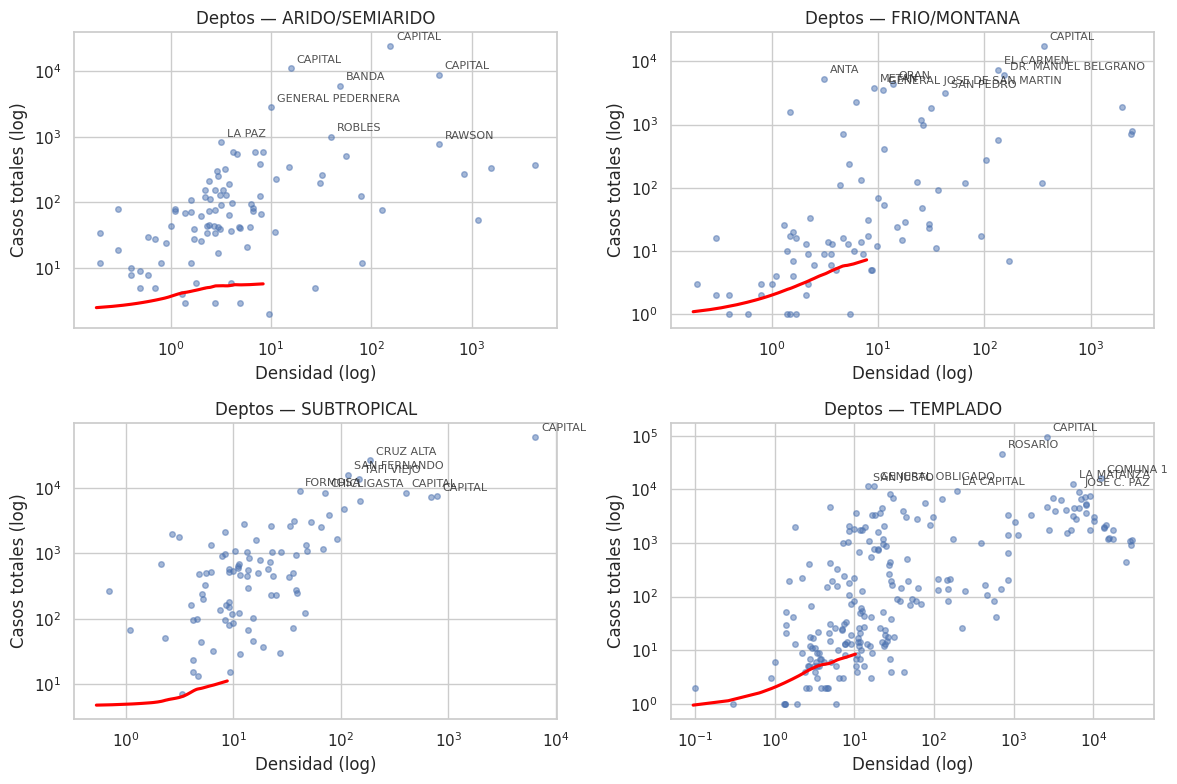

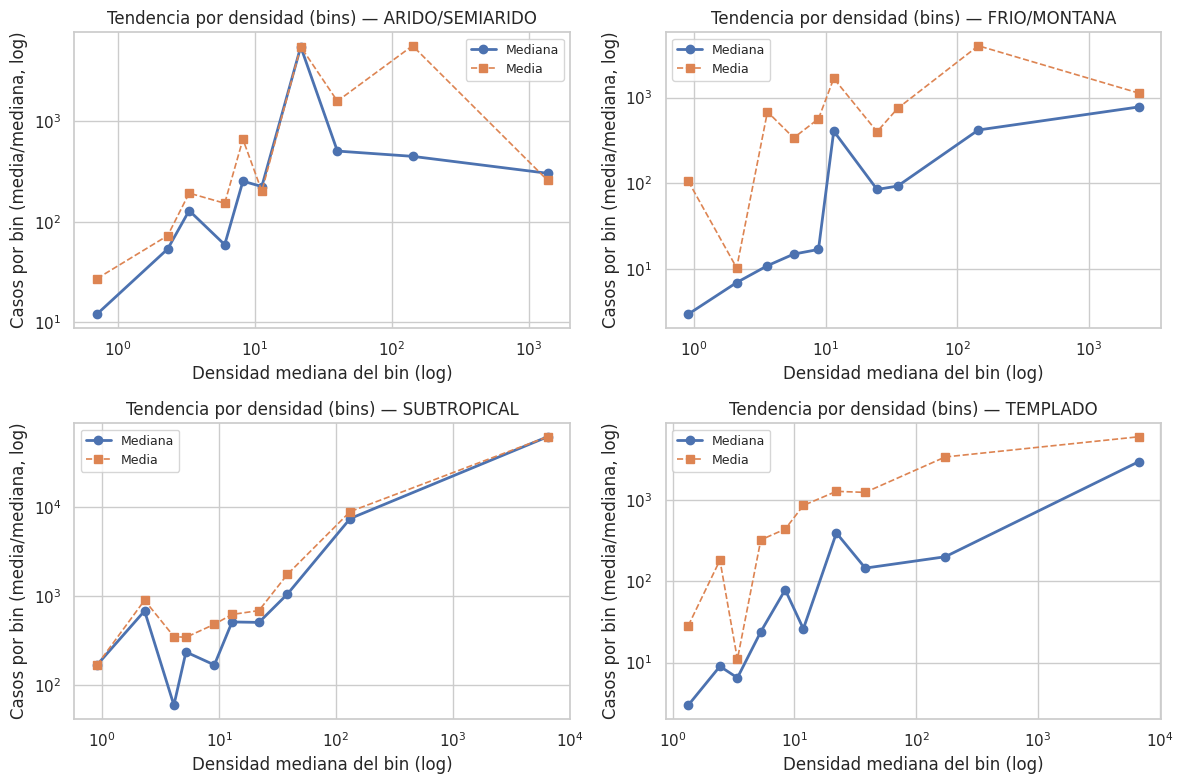

In [ ]:
# ======================================================
# HIPÓTESIS 4 : densidad -> casos (enero–junio desde 2023)
# ======================================================

# ---------- 0) DF base ----------
df_h4 = df_grouped.copy()

# ---------- 1) Validaciones ----------
need_cols = {
    "provincia_nombre","departamento_nombre","fecha_semana","clima_region",
    "densidad","cantidad_casos"
}
miss = [c for c in need_cols if c not in df_h4.columns]
if miss:
    raise ValueError(f"Faltan columnas requeridas: {miss}")

# Convertir fecha si no lo está
if not np.issubdtype(df_h4["fecha_semana"].dtype, np.datetime64):
    df_h4["fecha_semana"] = pd.to_datetime(df_h4["fecha_semana"], errors="coerce")

# ---------- 2) Filtro temporal y regional ----------
df_h4["anio"] = df_h4["fecha_semana"].dt.year
df_h4["mes"] = df_h4["fecha_semana"].dt.month

# Solo años >= 2023 y meses 1–6
df_h4 = df_h4.query("anio >= 2023 and 1 <= mes <= 6").copy()

reg_keep = {"TEMPLADO","SUBTROPICAL","ARIDO/SEMIARIDO","FRIO/MONTANA"}
df_h4 = df_h4[df_h4["clima_region"].isin(reg_keep)].dropna(subset=["densidad","cantidad_casos"]).copy()

if df_h4.empty:
    raise ValueError("No hay datos después del filtro por meses 1–6 y regiones válidas.")

print(f"✔️ Filtrado: {df_h4.shape[0]} filas (enero–junio, desde 2023)")

y = "cantidad_casos"
x = "densidad"

# ---------- 3) Funciones auxiliares ----------
def spearman(a,b):
    if len(a) < 3: return np.nan
    return pd.Series(a).corr(pd.Series(b), method="spearman")

def pearson(a,b):
    if len(a) < 3: return np.nan
    return pd.Series(a).corr(pd.Series(b), method="pearson")

def quantile_bins(x, q=10):
    r = pd.Series(x).rank(method="first")
    return pd.qcut(r, q=q, labels=[f"B{i}" for i in range(1,q+1)])

def summarize_by_bins(df, x="densidad", y="cantidad_casos", q=10):
    tmp = df.copy()
    tmp["_bin"] = quantile_bins(tmp[x], q=q)
    g = (tmp.groupby(["clima_region","_bin"], observed=False)
           .agg(dens_med=(x,"median"),
                y_mean=(y,"mean"),
                y_med=(y,"median"),
                n=(y,"count"))
           .reset_index())
    g = g.sort_values(["clima_region","dens_med"]).reset_index(drop=True)
    return g


# =====================================
# A) ANÁLISIS AGREGADO POR DEPARTAMENTO
# =====================================

agg = (df_h4.groupby(["clima_region","provincia_nombre","departamento_nombre"], observed=False)
         .agg(casos_totales=(y,"sum"), densidad=(x,"mean"))
         .reset_index())

print("\n=== Correlaciones POR DEPARTAMENTO (casos totales ~ densidad, ene–jun, >=2023) ===")
rows = []
for reg, g in agg.groupby("clima_region", observed=False):
    rows.append({
        "clima_region": reg,
        "Spearman": spearman(g["densidad"], g["casos_totales"]),
        "Pearson":  pearson(g["densidad"], g["casos_totales"]),
        "n_deptos": len(g)
    })
corr_dep = pd.DataFrame(rows).set_index("clima_region").sort_index()
display(corr_dep)

# ==========================================
# B) Scatter agregado por departamento (log)
# ==========================================

regs = sorted(df_h4["clima_region"].dropna().unique())

n = len(regs)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), squeeze=False)
for i, reg in enumerate(regs):
    ax = axes[i//ncols, i%ncols]
    g = agg[agg["clima_region"]==reg]
    ax.scatter(g["densidad"], g["casos_totales"], s=16, alpha=0.5)
    ax.set_xscale("log"); ax.set_yscale("log")
    try:
        sns.regplot(x=np.log1p(g["densidad"]), y=np.log1p(g["casos_totales"]),
                    lowess=True, scatter=False, ax=ax, line_kws={"color":"red"})
    except Exception:
        pass
    # Etiquetar outliers por cantidad de casos
    for _, r in g.nlargest(8, "casos_totales").iterrows():
        ax.annotate(r["departamento_nombre"], (r["densidad"], r["casos_totales"]),
                    textcoords="offset points", xytext=(4,4), fontsize=8, alpha=0.8)
    ax.set_title(f"Deptos — {reg}")
    ax.set_xlabel("Densidad (log)"); ax.set_ylabel("Casos totales (log)")
for j in range(i+1, nrows*ncols): fig.delaxes(axes[j//ncols, j%ncols])
plt.tight_layout(); plt.show()


# ======================================================
# C) Tendencia por bins (igual N por bin) en agregado
# ======================================================

bins_dep = summarize_by_bins(
    agg.rename(columns={"casos_totales": "Y"}), x="densidad", y="Y", q=10
)

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 4*nrows), squeeze=False)
for i, reg in enumerate(regs):
    ax = axes[i//ncols, i%ncols]
    g = bins_dep[bins_dep["clima_region"]==reg]
    ax.plot(g["dens_med"], g["y_med"], marker="o", linewidth=2, label="Mediana")
    ax.plot(g["dens_med"], g["y_mean"], marker="s", linestyle="--", linewidth=1.2, label="Media")
    ax.set_xscale("log"); ax.set_yscale("log")
    ax.set_title(f"Tendencia por densidad (bins) — {reg}")
    ax.set_xlabel("Densidad mediana del bin (log)")
    ax.set_ylabel("Casos por bin (media/mediana, log)")
    ax.legend(fontsize=9)
for j in range(i+1, nrows*ncols): fig.delaxes(axes[j//ncols, j%ncols])
plt.tight_layout(); plt.show()


Podemos decir que la Hipotesis 5 es correcta.
Vemos que el aumento mas grande de casos en todas las regiones, se encapsula en los meses de Febrero, Marzo y abril.

Mientras tanto los meses correspondiente a las estaciones de invierno y otoño. Practicamente la cantidad de caso es nula o minima.



## Hipotesis 6 PRUEBA GRUPO DE EDAD

PRUEBA PARA VER SI EL GRUPO DE EDAD TIENEN ALGUN PESO EN LOS CASOS CONFIRMADOS

Planteo: Un grupo de edad activo, por ejemplo de 20-24 años tiene mas probabilidad de tener dengue.

Comparar por region, agrupando por los grupos de edad los casos confirmados.

In [ ]:

# ---------- 0) Base ----------
df_age = df_grouped.copy()


# ---------- 1) Validaciones ----------
needed_cols = {"clima_region", "grupo_edad_id", "cantidad_casos", "fecha_semana"}
missing = [c for c in needed_cols if c not in df_age.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

# Asegurar tipo fecha
if not pd.api.types.is_datetime64_any_dtype(df_age["fecha_semana"]):
    df_age["fecha_semana"] = pd.to_datetime(df_age["fecha_semana"], errors="coerce")

# ---------- 2) Filtro temporal ----------
df_age["anio"] = df_age["fecha_semana"].dt.year
df_age = df_age[df_age["anio"] >= 2023].copy()

# ---------- 3) Agrupación ----------
casos_region_edad = (
    df_age.groupby(["clima_region", "grupo_edad_id"], observed=False)
    .agg(casos_totales=("cantidad_casos", "sum"))
    .reset_index()
)

# Calcular proporción relativa dentro de cada región
casos_region_edad["prop_region"] = (
    casos_region_edad.groupby("clima_region")["casos_totales"]
    .transform(lambda x: x / x.sum())
)

display(casos_region_edad.sort_values(["clima_region","casos_totales"], ascending=[True,False]).head(20))
print("✔️ Dataframe listo: 'casos_region_edad' con totales y proporciones por región y grupo de edad.")

,clima_region,grupo_edad_id,casos_totales,prop_region
8,ARIDO/SEMIARIDO,9,17280,0.264528
6,ARIDO/SEMIARIDO,6,12973,0.198595
7,ARIDO/SEMIARIDO,7,10675,0.163416
5,ARIDO/SEMIARIDO,5,6439,0.098570
3,ARIDO/SEMIARIDO,3,6188,0.094728
4,ARIDO/SEMIARIDO,4,5595,0.085650
2,ARIDO/SEMIARIDO,2,4567,0.069913
1,ARIDO/SEMIARIDO,1,1353,0.020712
0,ARIDO/SEMIARIDO,0,253,0.003873
9,ARIDO/SEMIARIDO,99,1,0.000015


✔️ Dataframe listo: 'casos_region_edad' con totales y proporciones por región y grupo de edad.


,n_nulos
provincia_nombre,0
departamento_nombre,0
anio,0
semana_epidemiologica,0
fecha_semana,0
temp_sem_prom,0
hum_sem_prom,0
prec_sem_prom,0
clima_region,0
densidad,0


,clima_region,grupo_edad_label,casos_totales,prop_region
8,ARIDO/SEMIARIDO,09 - De 45 a 65 años,17280,0.264528
6,ARIDO/SEMIARIDO,06 - De 25 a 34 años,12973,0.198595
7,ARIDO/SEMIARIDO,07 - De 35 a 44 años,10675,0.163416
5,ARIDO/SEMIARIDO,05 - De 20 a 24 años,6439,0.098570
3,ARIDO/SEMIARIDO,03 - De 10 a 14 años,6188,0.094728
4,ARIDO/SEMIARIDO,04 - De 15 a 19 años,5595,0.085650
2,ARIDO/SEMIARIDO,02 - De 5 a 9 años,4567,0.069913
1,ARIDO/SEMIARIDO,01 - De 2 a 4 años,1353,0.020712
0,ARIDO/SEMIARIDO,00 - Posneonato (29 hasta 365 dÍas),253,0.003873
9,ARIDO/SEMIARIDO,99 - Sin Especificar,1,0.000015


✔️ 'casos_region_edad' listo con etiquetas de edad y proporciones por región.


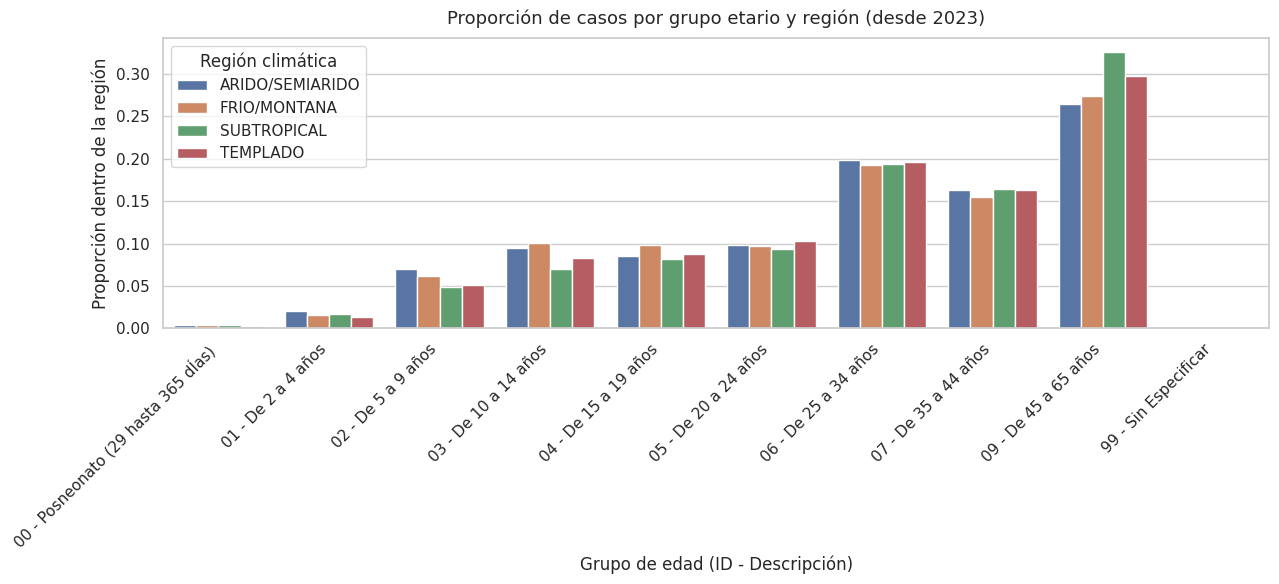

In [ ]:
# ============================================================
# Casos por grupo etario y región (desde 2023)
# Etiquetas: "<grupo_edad_id> - <grupo_edad_desc>"
# ============================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------- 0) Base --------
df_age = df_grouped.copy()
display(df_age.isna().sum().sort_values(ascending=False).to_frame("n_nulos"))


# -------- 1) Validaciones mínimas --------
needed = {"clima_region", "cantidad_casos", "fecha_semana"}
missing = [c for c in needed if c not in df_age.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

if not pd.api.types.is_datetime64_any_dtype(df_age["fecha_semana"]):
    df_age["fecha_semana"] = pd.to_datetime(df_age["fecha_semana"], errors="coerce")

# Confirmar columnas de edad
has_id   = "grupo_edad_id"   in df_age.columns
has_desc = "grupo_edad_desc" in df_age.columns
if not (has_id or has_desc):
    raise ValueError("No encuentro columnas de edad (grupo_edad_id / grupo_edad_desc).")

# -------- 2) Filtro temporal --------
df_age["anio"] = df_age["fecha_semana"].dt.year
df_age = df_age[df_age["anio"] >= 2023].copy()

# -------- 3) Construir etiqueta combinada --------
# Preferimos usar ambos: id + desc. Si solo hay uno, usamos el disponible.
if has_id and has_desc:
    # Normalizar desc y resolver posibles inconsistencias (elegimos la moda por id)
    desc_mode = (
        df_age.dropna(subset=["grupo_edad_id", "grupo_edad_desc"])
              .groupby("grupo_edad_id")["grupo_edad_desc"]
              .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
              .reset_index()
    )
    df_age = df_age.merge(desc_mode, on="grupo_edad_id", how="left", suffixes=("", "_resolved"))
    df_age["grupo_edad_desc_final"] = df_age["grupo_edad_desc_resolved"].fillna(df_age["grupo_edad_desc"])
    # etiqueta "<id> - <desc>"
    df_age["grupo_edad_label"] = df_age["grupo_edad_id"].astype(str).str.zfill(2) + " - " + df_age["grupo_edad_desc_final"].astype(str)
    # ordenar por id
    order_labels = (
        df_age[["grupo_edad_id","grupo_edad_label"]]
        .drop_duplicates()
        .sort_values("grupo_edad_id")
        ["grupo_edad_label"].tolist()
    )
    age_x = "grupo_edad_label"
elif has_id:
    df_age["grupo_edad_label"] = df_age["grupo_edad_id"].astype(str).str.zfill(2)
    order_labels = (
        df_age[["grupo_edad_id","grupo_edad_label"]]
        .drop_duplicates()
        .sort_values("grupo_edad_id")
        ["grupo_edad_label"].tolist()
    )
    age_x = "grupo_edad_label"
else:  # solo descripción
    df_age["grupo_edad_label"] = df_age["grupo_edad_desc"].astype(str)
    order_labels = sorted(df_age["grupo_edad_label"].unique().tolist())
    age_x = "grupo_edad_label"

# -------- 4) Agregación y proporciones --------
casos_region_edad = (
    df_age
    .groupby(["clima_region", age_x], observed=False)
    .agg(casos_totales=("cantidad_casos", "sum"))
    .reset_index()
)
casos_region_edad["prop_region"] = (
    casos_region_edad.groupby("clima_region")["casos_totales"]
    .transform(lambda x: x / x.sum())
)

display(casos_region_edad.sort_values(["clima_region","casos_totales"], ascending=[True,False]).head(20))
print("✔️ 'casos_region_edad' listo con etiquetas de edad y proporciones por región.")

# -------- 5) Gráfico --------
sns.set(style="whitegrid")
plt.figure(figsize=(13,6))
sns.barplot(
    data=casos_region_edad,
    x=age_x,
    y="prop_region",
    hue="clima_region",
    order=order_labels
)
plt.title("Proporción de casos por grupo etario y región (desde 2023)", fontsize=13, pad=10)
plt.xlabel("Grupo de edad (ID - Descripción)")
plt.ylabel("Proporción dentro de la región")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Región climática")
plt.tight_layout()
plt.show()


La Hipotesis 6 ha sido incorrecta. Pero con el analisis de las edades por grupo, podemos apreciar que hay como 2 escalones. Uno entre los 5 a 24 años que tienen una tasa media de casos aproximadamente del 8 porciento por zona.
y el otro entre los 24 a 65 años con un porcentaje mas alto de casos llegando a un promedio del 20% aproximadamente por zona.

Lo que podemos concluir que hay rangos de edad que influyen en los casos, probalemente porque esten mas expuestos.

,n_nulos
provincia_nombre,0
departamento_nombre,0
anio,0
semana_epidemiologica,0
fecha_semana,0
temp_sem_prom,0
hum_sem_prom,0
prec_sem_prom,0
clima_region,0
densidad,0


,clima_region,grupo_edad_desc_std,casos_totales,prop_region
8,ARIDO/SEMIARIDO,65+,17280,0.264528
5,ARIDO/SEMIARIDO,25 a 34,12973,0.198595
6,ARIDO/SEMIARIDO,35 a 44,10675,0.163416
4,ARIDO/SEMIARIDO,20 a 24,6439,0.098570
2,ARIDO/SEMIARIDO,10 a 14,6188,0.094728
3,ARIDO/SEMIARIDO,15 a 19,5595,0.085650
7,ARIDO/SEMIARIDO,5 a 9,4567,0.069913
1,ARIDO/SEMIARIDO,1 a 4,1353,0.020712
0,ARIDO/SEMIARIDO,0 a 0,253,0.003873
9,ARIDO/SEMIARIDO,DESCONOCIDO,1,0.000015


✔️ 'casos_region_edad' listo con etiquetas std y proporciones por región.


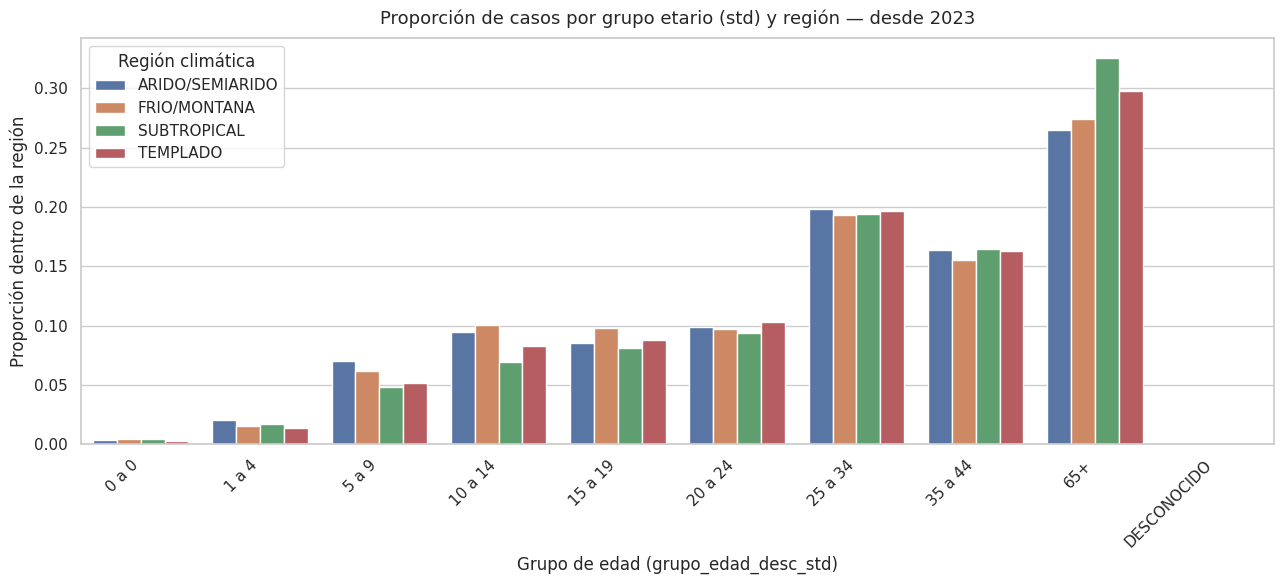

In [ ]:
# ============================================================
# Casos por grupo etario y región (desde 2023)
# Etiquetas: "grupo_edad_desc_std"
# ============================================================

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -------- 0) Base --------
df_age = df_grouped.copy()
display(df_age.isna().sum().sort_values(ascending=False).to_frame("n_nulos"))

# -------- 1) Validaciones mínimas --------
needed = {"clima_region", "cantidad_casos", "fecha_semana", "grupo_edad_desc_std"}
missing = [c for c in needed if c not in df_age.columns]
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

# Fecha a datetime
if not pd.api.types.is_datetime64_any_dtype(df_age["fecha_semana"]):
    df_age["fecha_semana"] = pd.to_datetime(df_age["fecha_semana"], errors="coerce")

# -------- 2) Filtro temporal --------
df_age["anio"] = df_age["fecha_semana"].dt.year
df_age = df_age[df_age["anio"] >= 2023].copy()

# (Opcional) limitar a enero–junio como en otras hipótesis
# df_age["mes"] = df_age["fecha_semana"].dt.month
# df_age = df_age.query("1 <= mes <= 6").copy()

# -------- 3) Etiqueta y orden por rango etario --------
age_x = "grupo_edad_desc_std"

# Extraer límite inferior numérico para ordenar (ej: "0-4" -> 0, "65+" -> 65)
def lower_bound(s: str):
    if pd.isna(s):
        return float("inf")
    m = re.search(r"(\d+)", str(s))
    return float(m.group(1)) if m else float("inf")

order_df = (
    df_age[[age_x]].dropna().drop_duplicates()
        .assign(_lb=lambda d: d[age_x].map(lower_bound))
        .sort_values(["_lb", age_x])
)
order_labels = order_df[age_x].tolist()

# -------- 4) Agregación y proporciones --------
casos_region_edad = (
    df_age
    .groupby(["clima_region", age_x], observed=False)
    .agg(casos_totales=("cantidad_casos", "sum"))
    .reset_index()
)

casos_region_edad["prop_region"] = (
    casos_region_edad.groupby("clima_region")["casos_totales"]
    .transform(lambda x: x / x.sum())
)

display(
    casos_region_edad
    .sort_values(["clima_region","casos_totales"], ascending=[True,False])
    .head(20)
)
print("✔️ 'casos_region_edad' listo con etiquetas std y proporciones por región.")

# -------- 5) Gráfico --------
sns.set(style="whitegrid")
plt.figure(figsize=(13,6))
sns.barplot(
    data=casos_region_edad,
    x=age_x,
    y="prop_region",
    hue="clima_region",
    order=order_labels
)
plt.title("Proporción de casos por grupo etario (std) y región — desde 2023", fontsize=13, pad=10)
plt.xlabel("Grupo de edad (grupo_edad_desc_std)")
plt.ylabel("Proporción dentro de la región")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Región climática")
plt.tight_layout()
plt.show()


In [ ]:
# ======================================================
# Calcular media de casos por región (enero–junio desde 2023)
# ======================================================

# Reutilizamos el dataframe filtrado en la celda anterior
df_filtered_periodo = df_periodo_Anual.copy()

# Validar que la columna de casos exista
case_col = next((c for c in ["cantidad_casos","casos","n_casos","count_casos"] if c in df_filtered_periodo.columns), None)
if case_col is None:
    raise ValueError("No encuentro la columna de casos (cantidad_casos/casos/n_casos/count_casos).")

# Agrupar por región y calcular la media de casos
mean_cases_by_region = df_filtered_periodo.groupby("clima_region")[case_col].mean().reset_index()

display(mean_cases_by_region)

print("✔️ Media de casos por región (enero–junio, desde 2023) calculada.")

# ======================================================
# Definir rangos (bajo, medio, alto) basados en la media
# ======================================================

# Calcular los cuartiles de la media de casos
quartiles = mean_cases_by_region[case_col].quantile([0.33, 0.66]).to_list()

# Definir los rangos
bajo_threshold = quartiles[0]
medio_threshold = quartiles[1]

def categorize_region(mean_cases):
    if mean_cases <= bajo_threshold:
        return "Bajo"
    elif mean_cases <= medio_threshold:
        return "Medio"
    else:
        return "Alto"

mean_cases_by_region["rango_casos"] = mean_cases_by_region[case_col].apply(categorize_region)

print("\nRangos de casos por región:")
display(mean_cases_by_region)



,clima_region,cantidad_casos
0,ARIDO/SEMIARIDO,9.644334
1,FRIO/MONTANA,9.848417
2,SUBTROPICAL,12.115000
3,TEMPLADO,15.271335


✔️ Media de casos por región (enero–junio, desde 2023) calculada.

Rangos de casos por región:


,clima_region,cantidad_casos,rango_casos
0,ARIDO/SEMIARIDO,9.644334,Bajo
1,FRIO/MONTANA,9.848417,Medio
2,SUBTROPICAL,12.115000,Alto
3,TEMPLADO,15.271335,Alto


In [ ]:
# # Calculate total cases per month for each region across all years (from 2023 onwards)
# total_cases_by_month_region = mensual_region.groupby(["clima_region", "mes"]).agg(
#     total_casos=("cantidad_casos", "sum"),
#     mean_casos=("cantidad_casos", "mean"),
#     median_casos=("cantidad_casos", "median"),
#     q33_casos=("cantidad_casos", lambda x: x.quantile(0.33)),
#     q66_casos=("cantidad_casos", lambda x: x.quantile(0.66)),
#     mes_nombre=("mes_nombre", "first") # Get the month name
# ).reset_index()

# # Order by region and then by month
# total_cases_by_month_region = total_cases_by_month_region.sort_values(["clima_region", "mes"])

# print("Case statistics per month per region (from 2023):")
# display(total_cases_by_month_region)

